In [167]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
import pandas as pd
import subprocess
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator
import global_importance 
import tfr_evaluate, util
from test_to_bw_fast import read_model, get_config
import explain
import embed
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
def boxplot_with_test(data, x, y, pairs):
    plotting_parameters = {
                            'data':    data,
                            'x':       x,
                            'y':       y}
    pvalues = [mannwhitneyu(data[data[x]==pair[0]][y], 
                            data[data[x]==pair[1]][y]).pvalue for pair in pairs]
    ax = sns.boxplot(**plotting_parameters)
    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate();



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original vs. motifs removed: Custom statistical test, P_val:5.298e-04


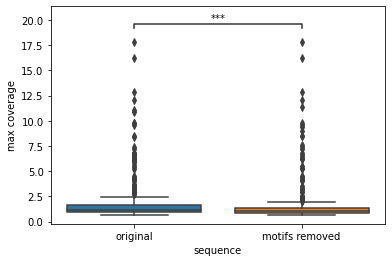

In [169]:
boxplot_with_test(ori_pred_pc3, 'sequence', 'max coverage', [('original', 'motifs removed')])

In [12]:
# load and get model layer
run_path = '../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
layer = -3
model, bin_size = read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    

In [8]:
# load and threshold data
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
threshold = 2
cell_line = 13
# C, X, Y = util.convert_tfr_to_np(testset, 3)
# thresholded_Y = Y[np.max(Y, axis=1)>2]
# idr_class = embed.label_idr_peaks(thresholded_C, cell_line)
# predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
# thresholded_Y.shape
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)


In [9]:
# threshold_mask = (Y.max(axis=1)>threshold).any(axis=-1)
# thresholded_Y = Y[threshold_mask]
# thresholded_X = X[threshold_mask]
# thresholded_C = C[threshold_mask]
# predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)



In [88]:
# low_seqs = np.load('low_seqs.npy', allow_pickle=True)
# low_cov = np.load('low_cov.npy', allow_pickle=True)
# low_pred = np.load('low_pred.npy', allow_pickle=True)


# GIA - remove motifs, do peaks dissapear?
Match GC content for peak & no peak, take peak motif, put in no peak, does a peak appear?

In [85]:
%%time
np.random.seed(42)
random_sample = thresholded_X[np.random.choice(thresholded_X.shape[0], 1000)]
seqs_with, seqs_removed = randomize_multiple_seqs(random_sample, 
                                                  'TGA.TCA', model, 13)
original_preds = embed.predict_np((np.array(seqs_with)), model, batch_size=32, reshape_to_2D=False)
pc3_del_preds = get_avg_preds(seqs_removed, model)

max_ori_pc3 = original_preds[:,:,cell_line].max(axis=1)
max_pred_pc3 = pc3_del_preds[:,:,cell_line].max(axis=1)
dfs = []
dfs.append(pd.DataFrame({'max coverage':max_ori_pc3, 
                   'sequence':['original' for i in range(len(max_ori_pc3))]}))
dfs.append(pd.DataFrame({'max coverage':max_pred_pc3, 
                        'sequence':['motifs removed' for i in range(len(max_pred_pc3))]}))
ori_pred_pc3 = pd.concat(dfs)

CPU times: user 1min 29s, sys: 23.1 s, total: 1min 52s
Wall time: 1min 57s


In [116]:
N, L, C = thresholded_Y.shape
binned_Y = thresholded_Y.reshape(N, L//bin_size, bin_size, C).mean(axis=-2)
mse = metrics.get_mse(binned_Y, 
                      predictions).mean(axis=1).mean(axis=-1)
pr = metrics.get_correlation_per_seq(binned_Y, 
                      predictions, take_avg=False)        
pr=np.array(pr).mean(axis=0)


In [28]:
best_seqs = np.argwhere((mse<7) & (pr>0.89)).flatten()


In [111]:
# select sequences based on seamonster regions
# N = 1000
# top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
left_N = np.argwhere(embed.select(embeddings, upper_lim_1=-1, lower_lim_2=5, idr='y')).flatten()
left_idr_indx = left_N[np.argwhere((mse[left_N]<6) & (pr[left_N]>0.95)).flatten()]
motif_pattern = 'TGA.TCA'



Choosing only IDR


../explain.py:972: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=[20, 2])


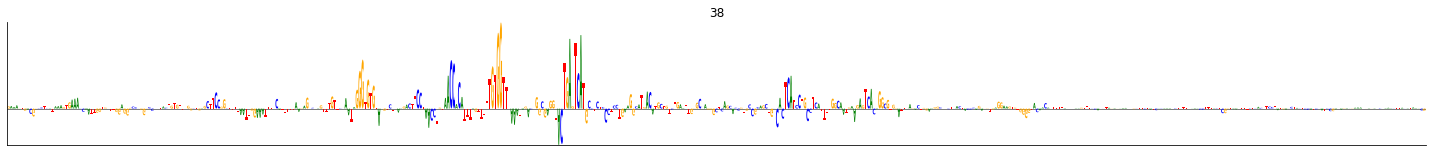

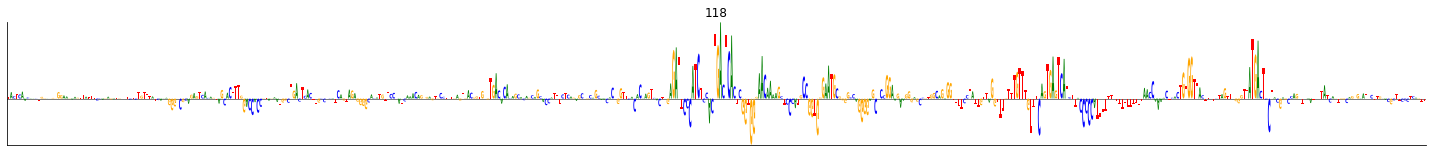

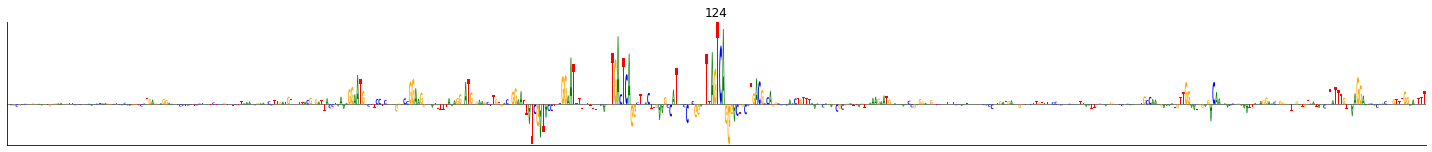

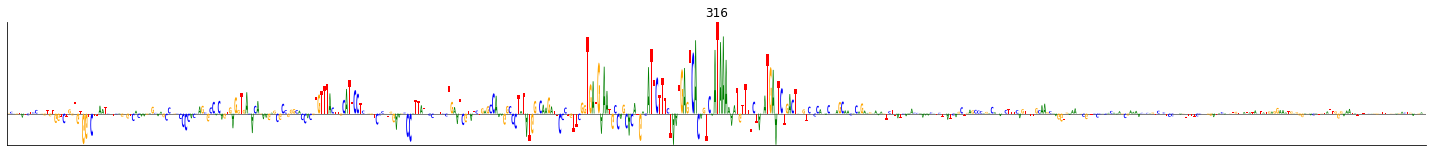

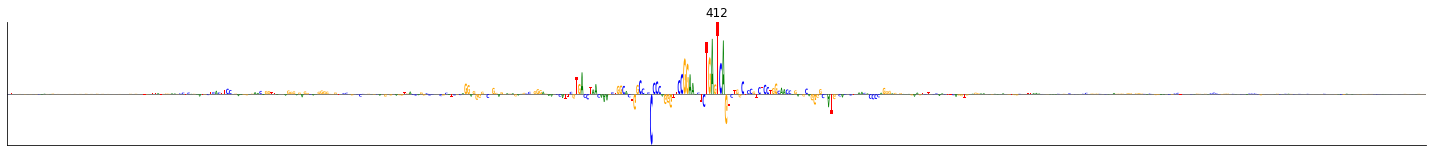

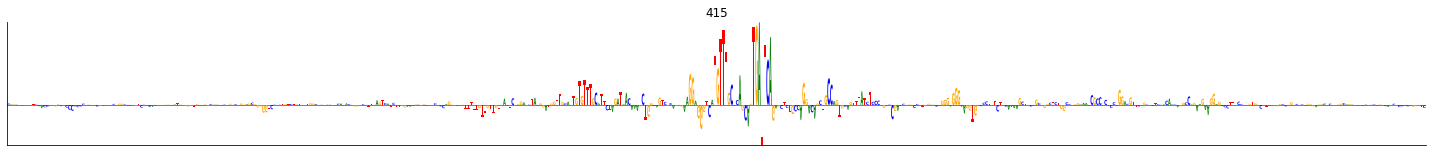

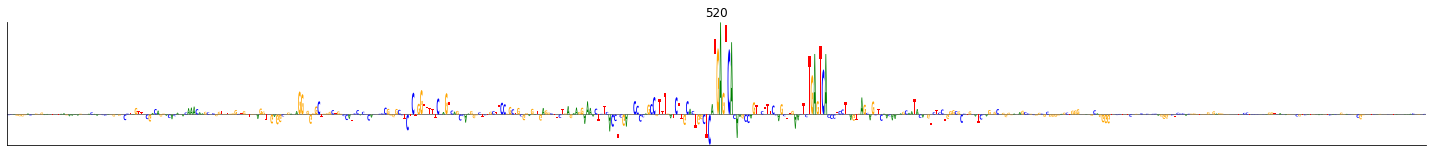

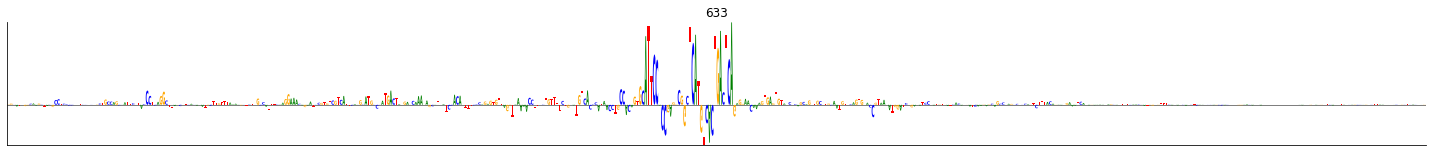

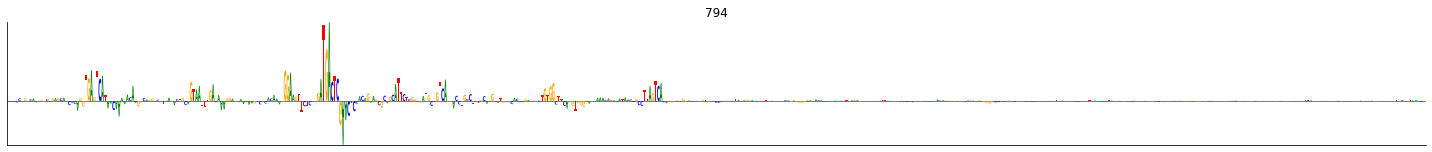

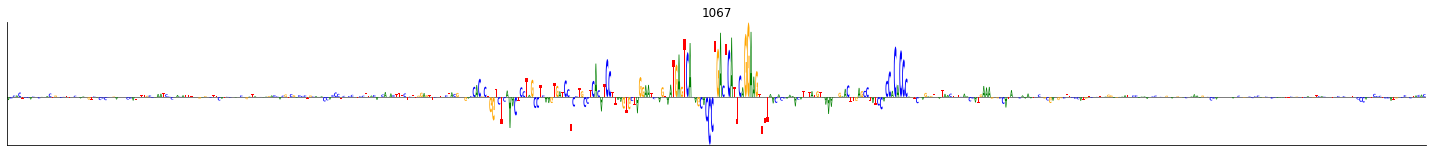

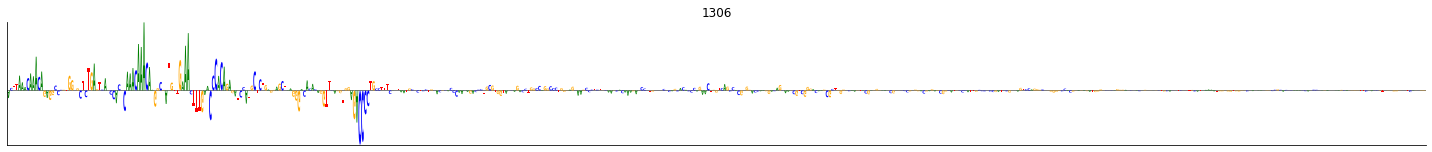

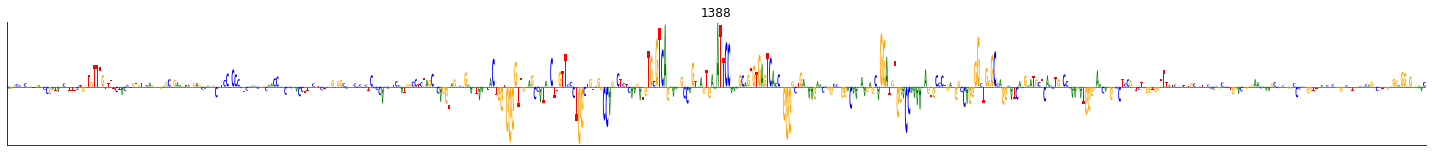

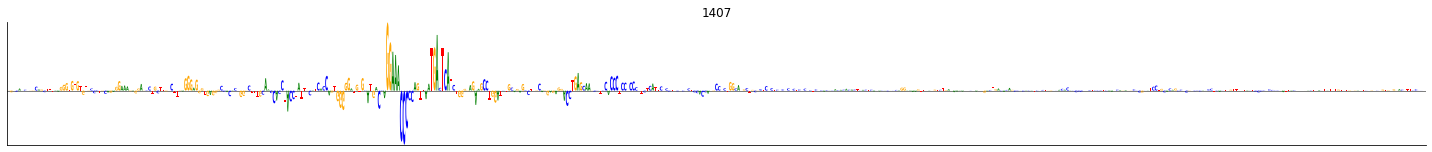

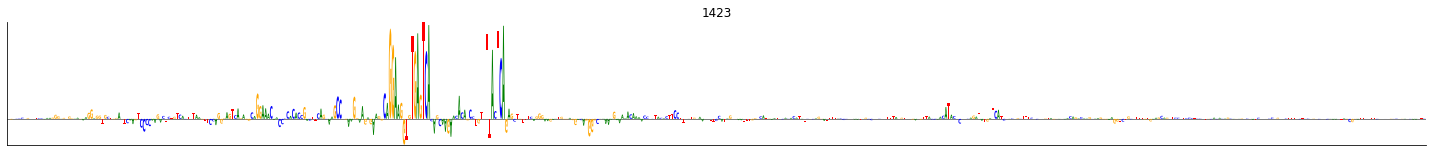

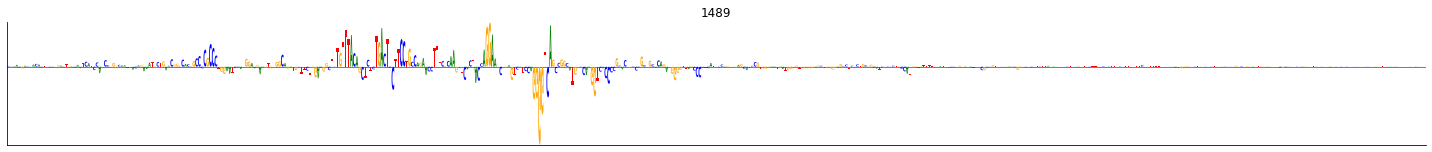

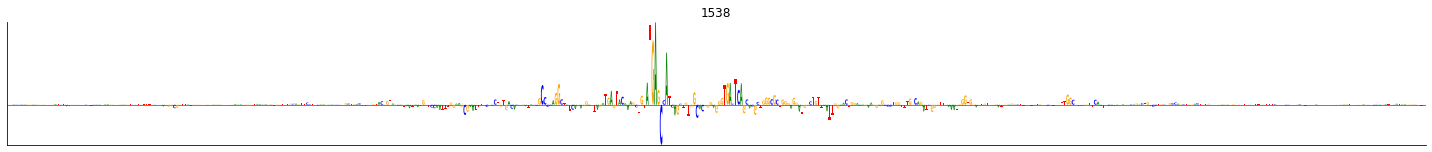

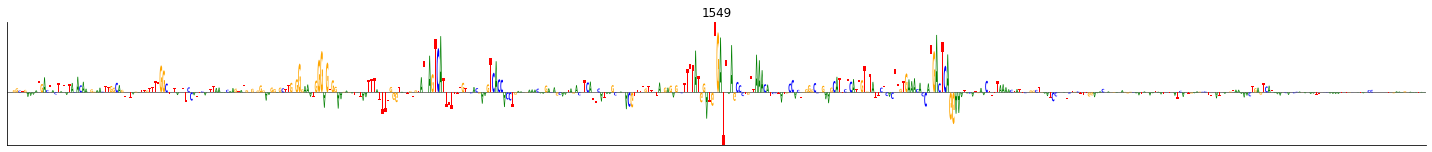

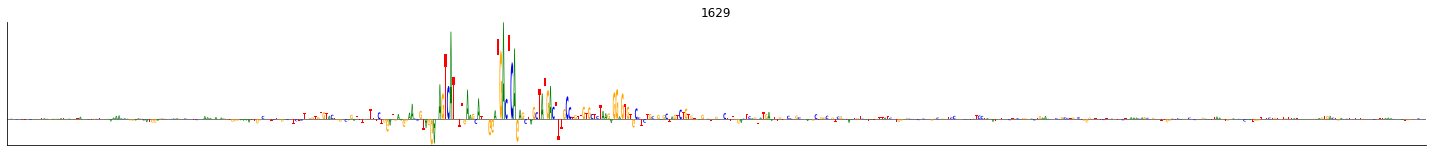

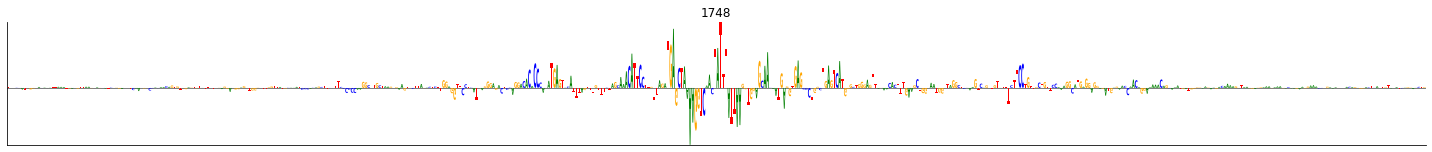

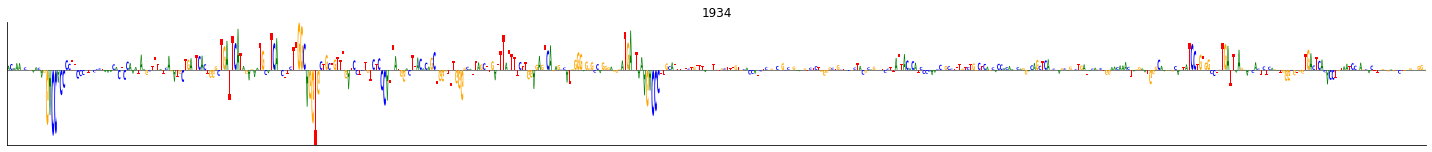

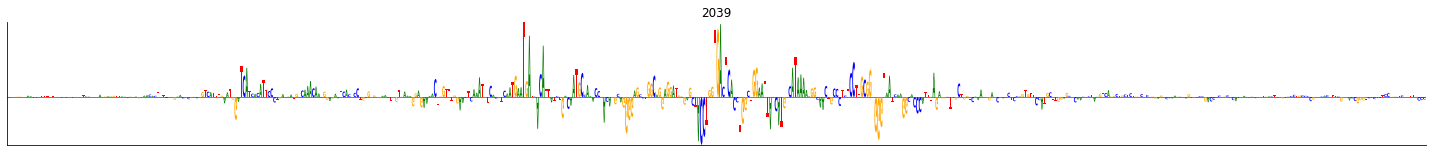

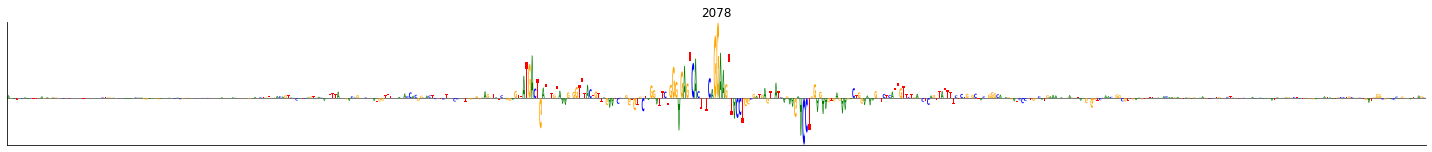

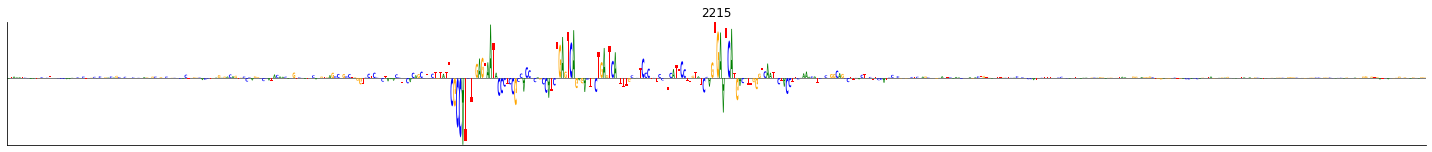

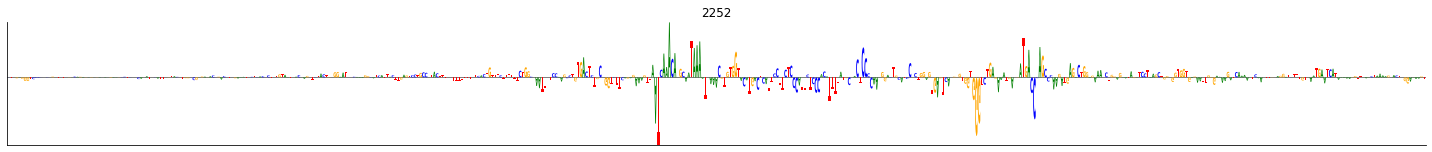

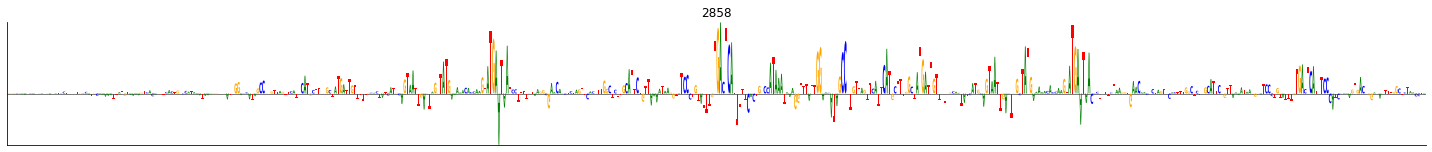

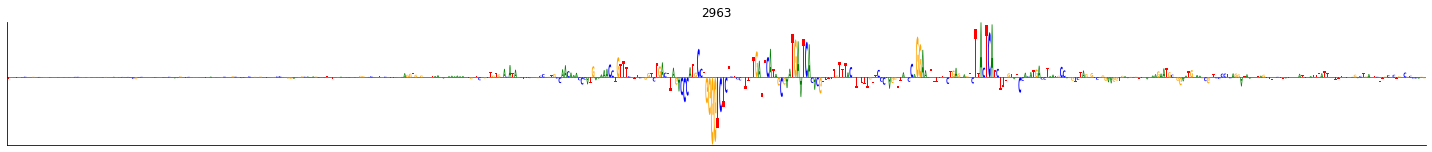

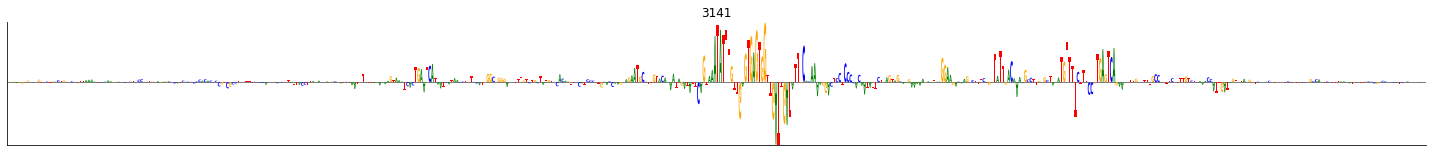

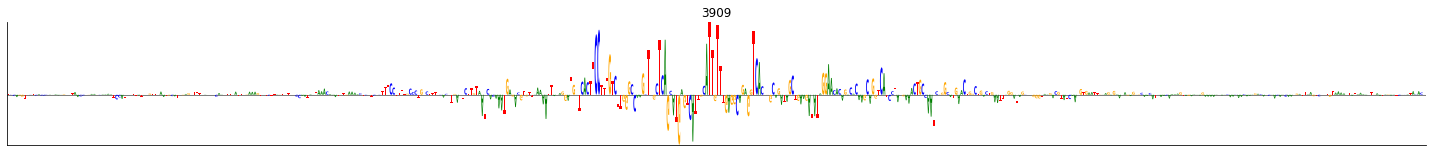

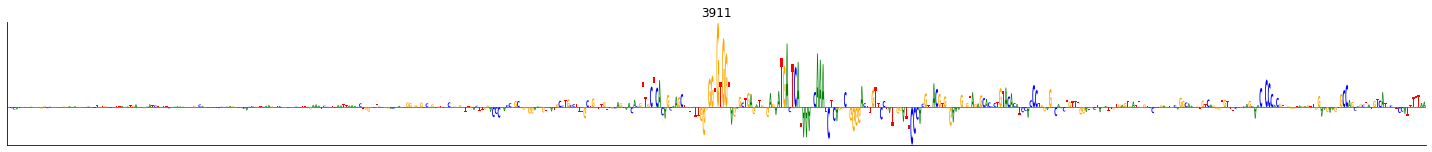

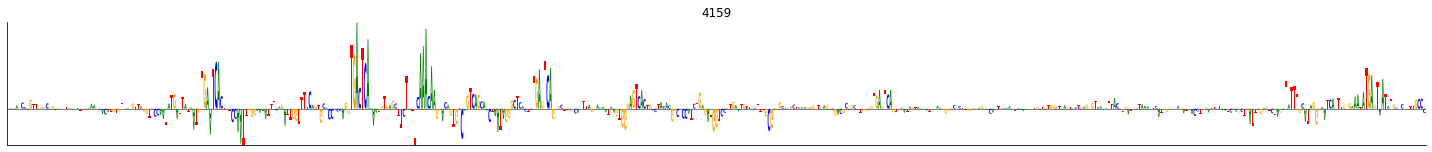

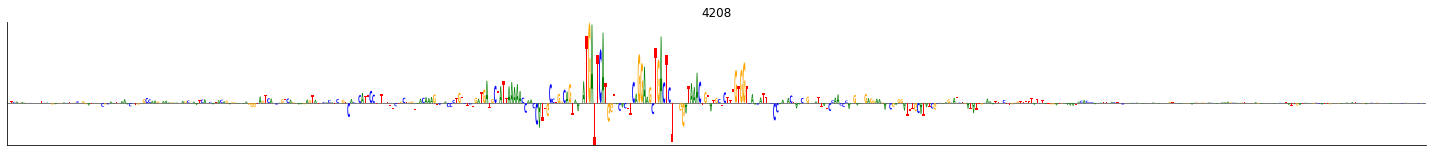

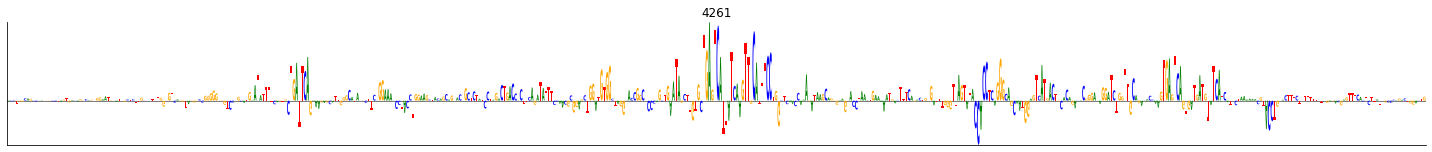

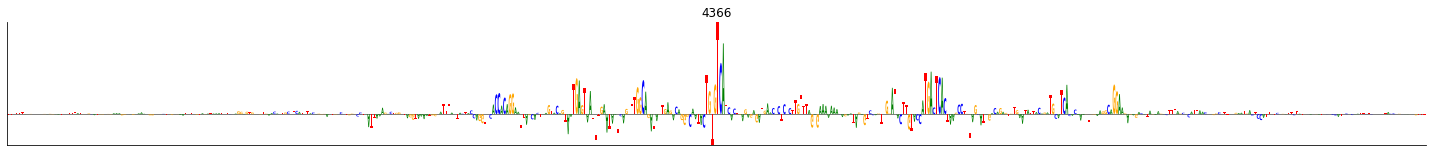

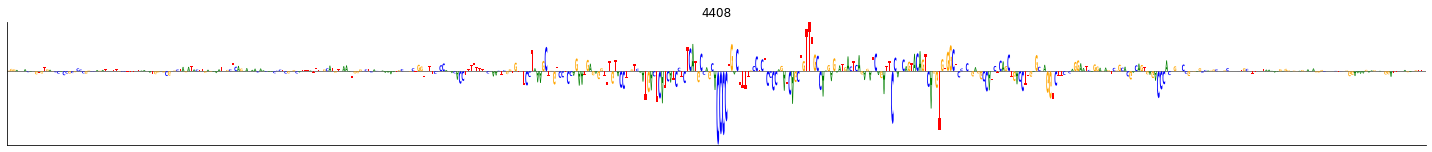

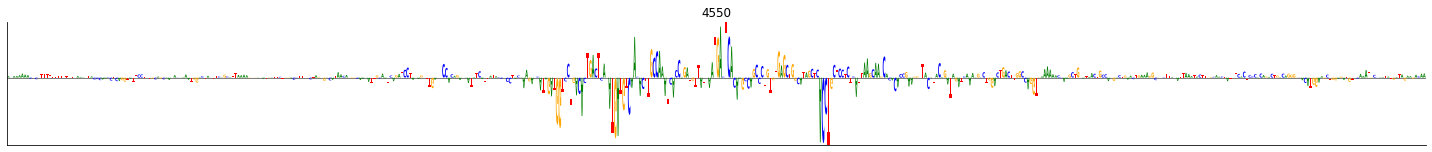

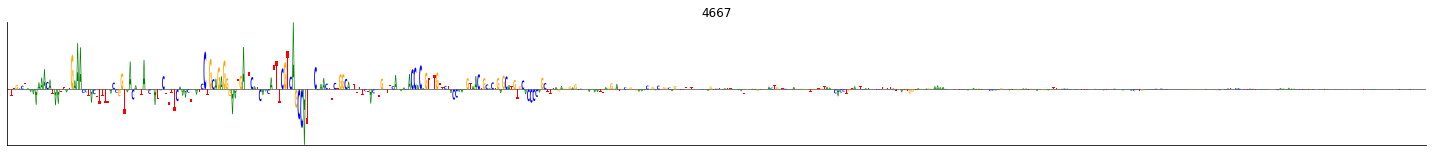

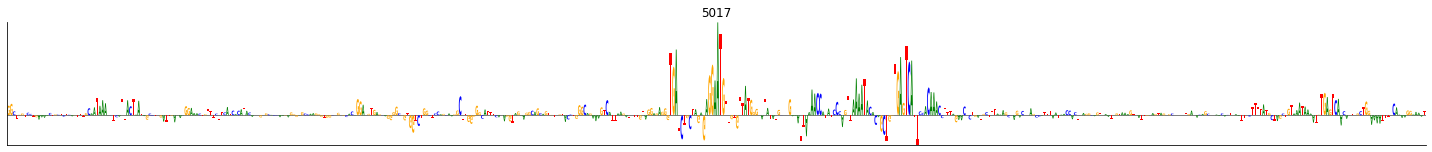

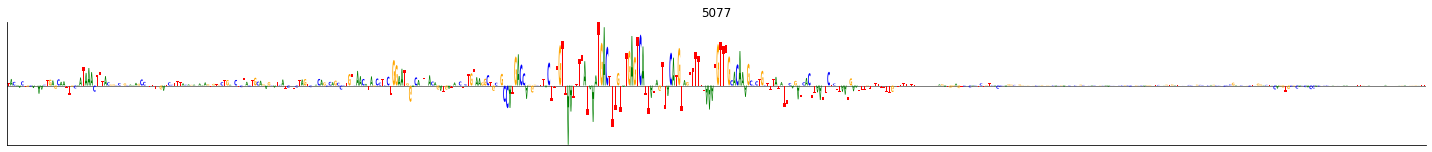

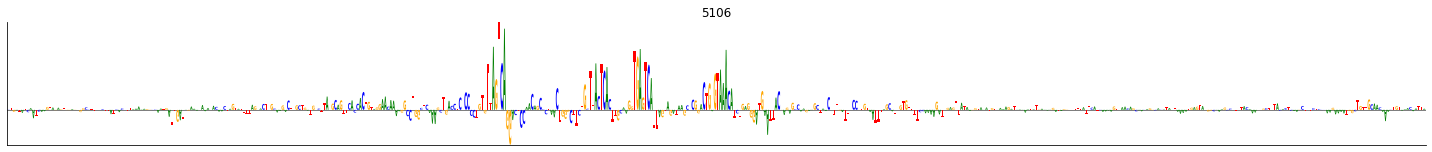

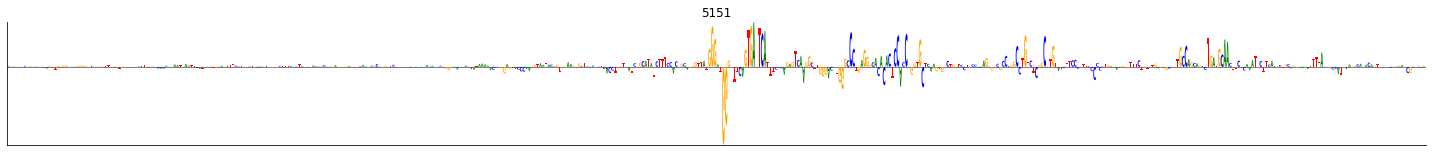

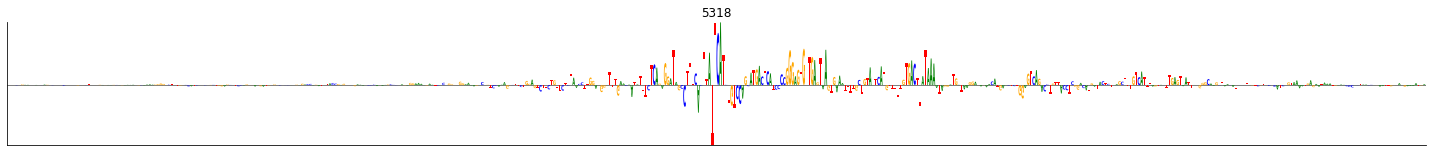

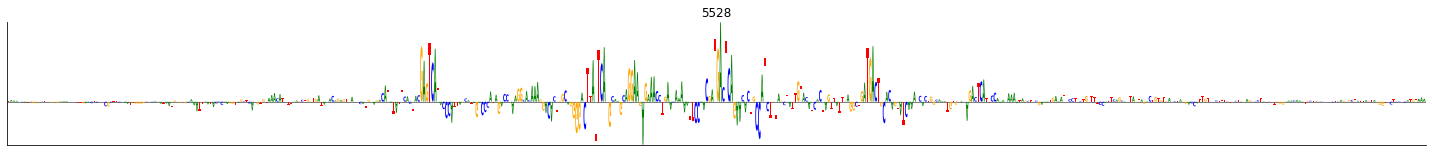

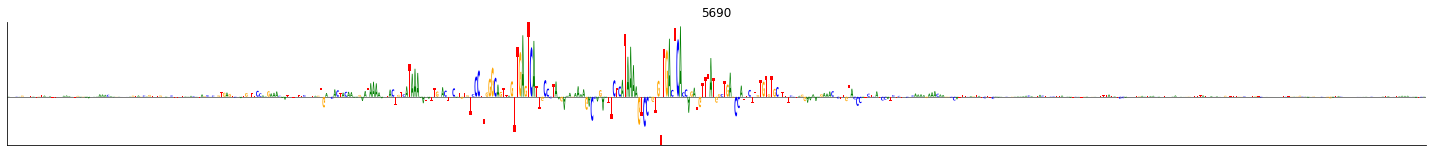

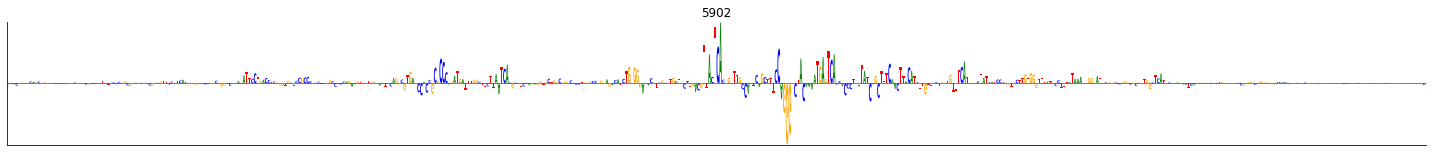

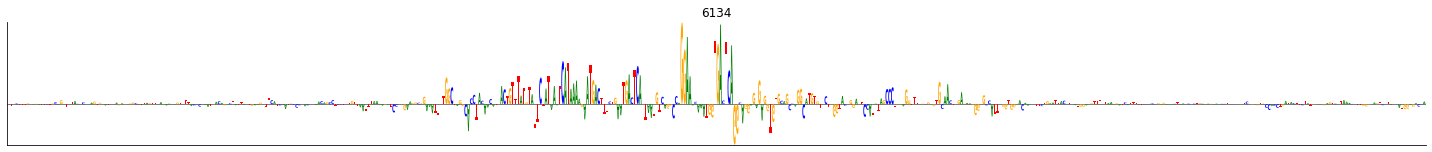

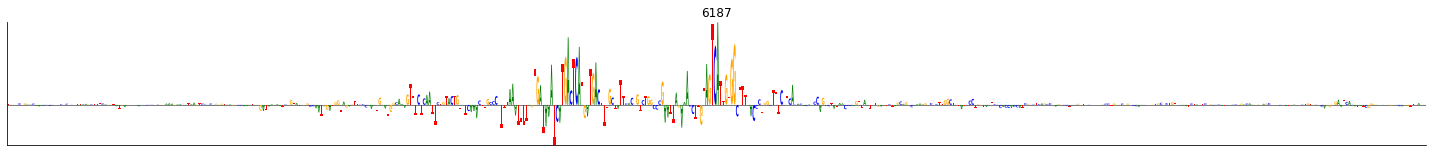

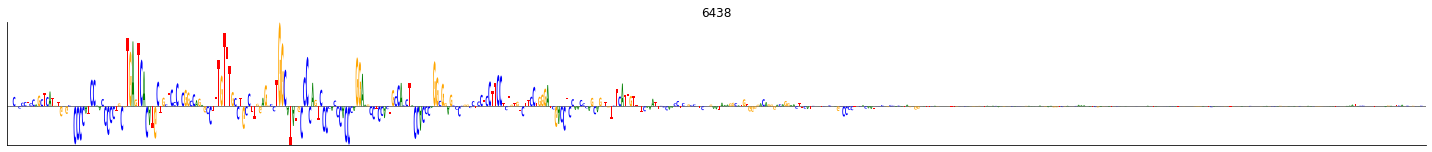

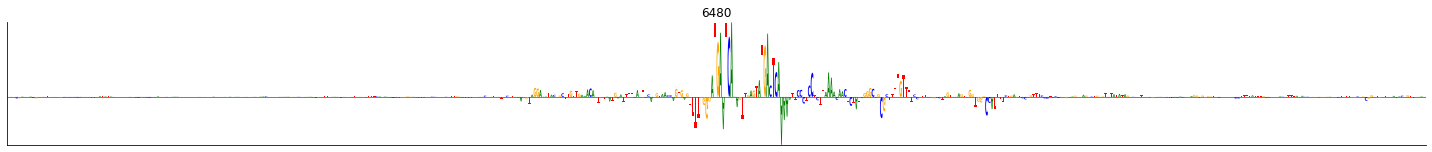

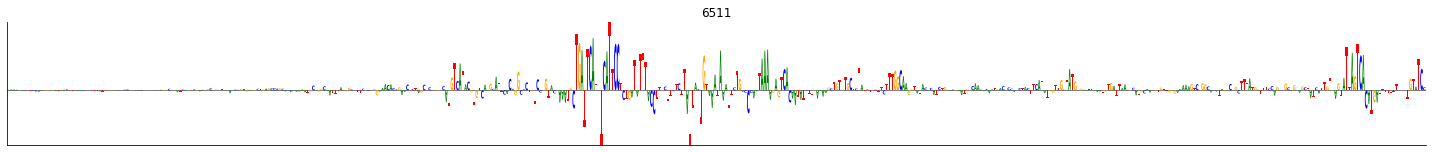

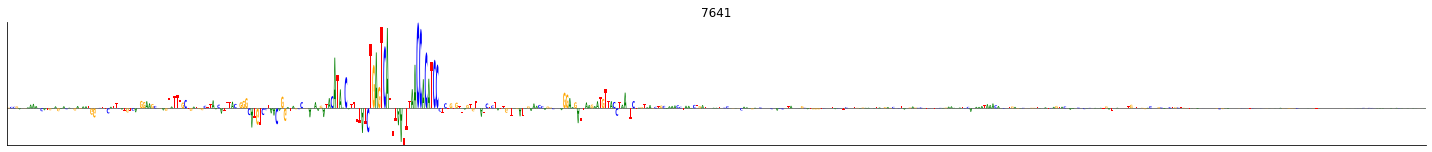

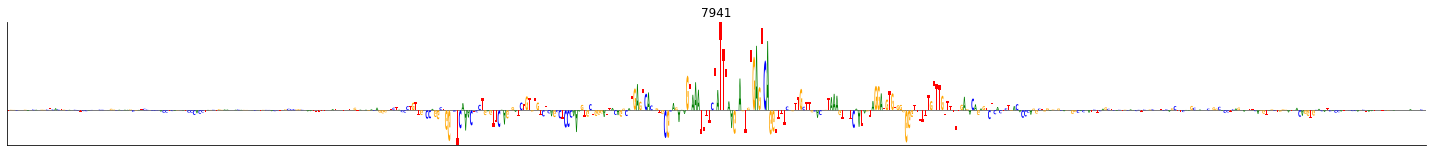

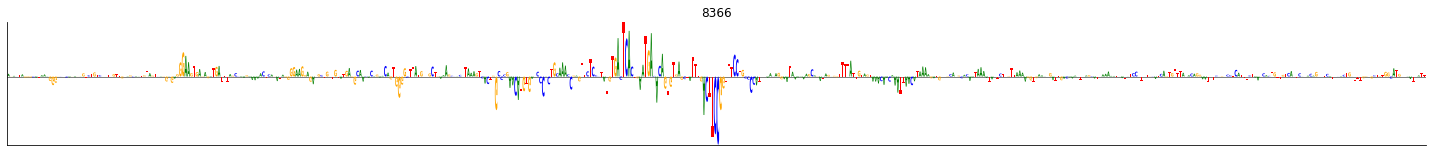

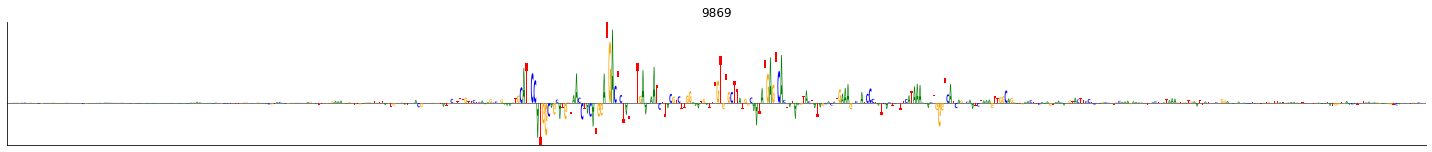

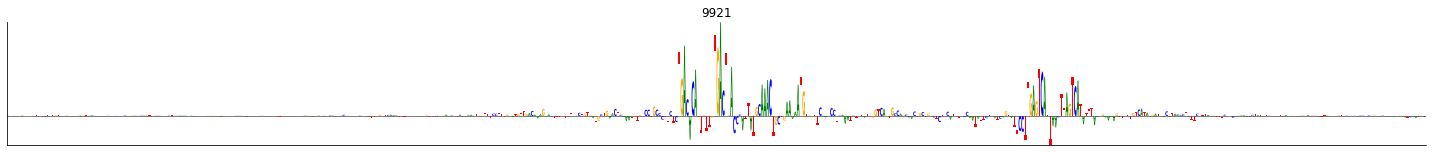

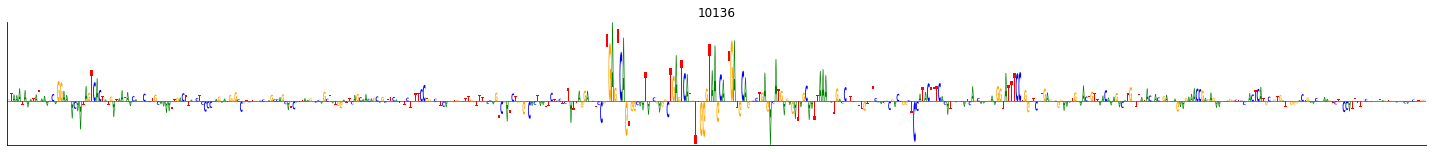

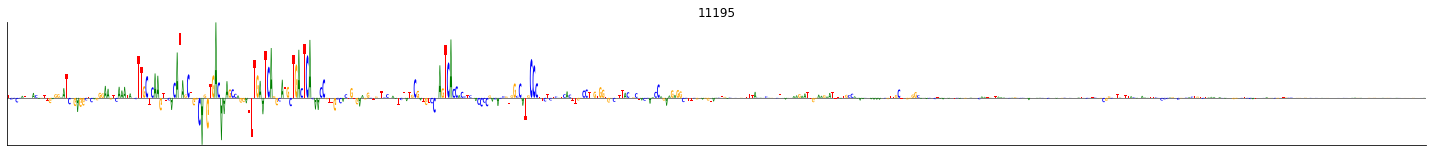

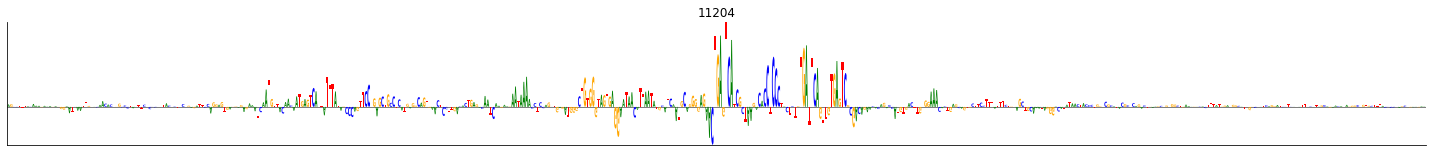

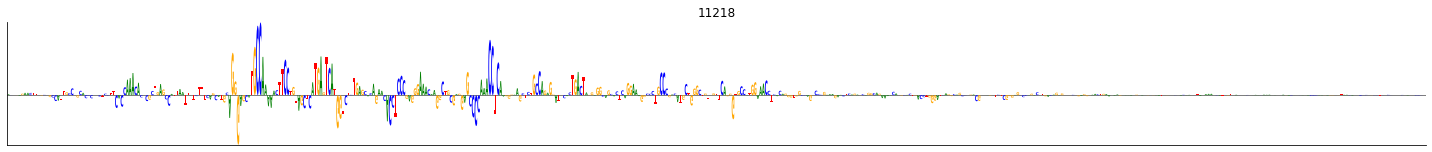

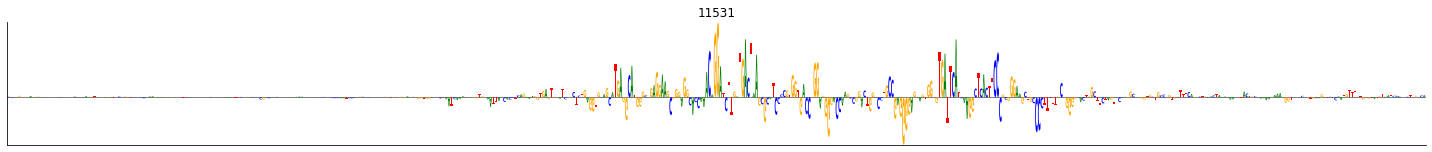

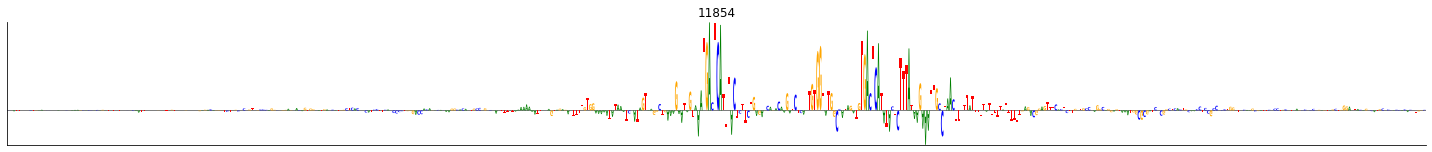

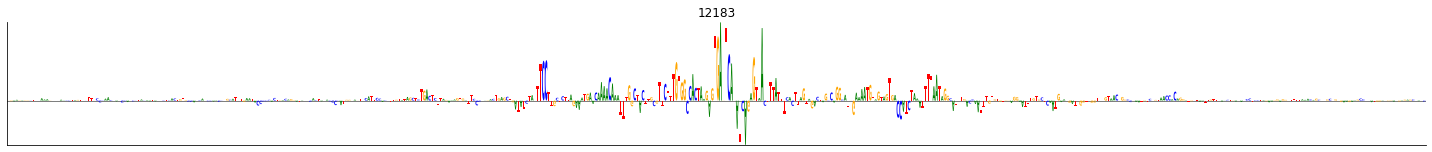

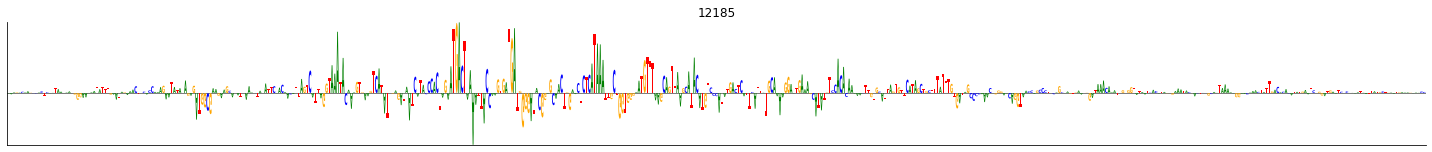

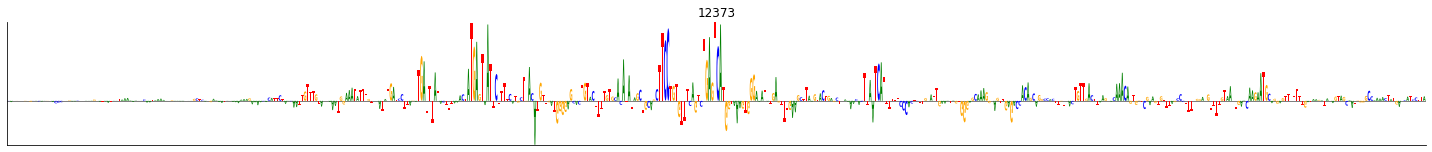

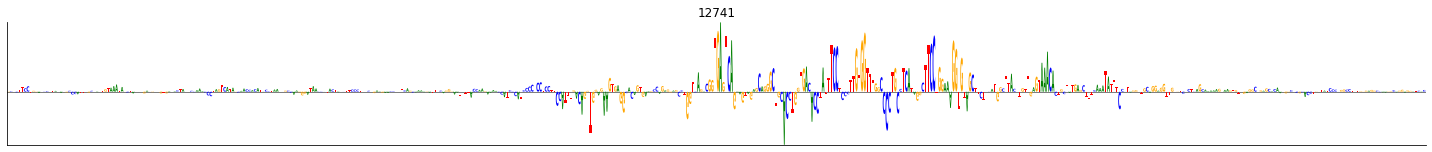

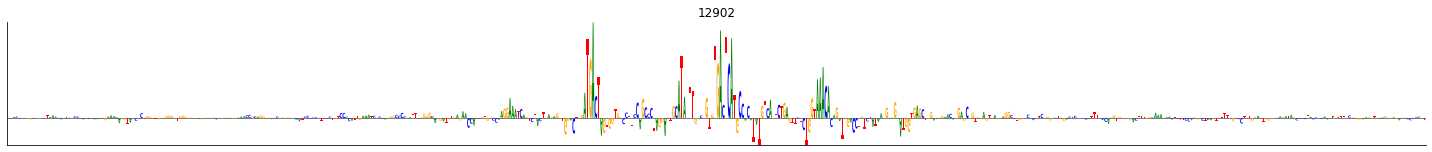

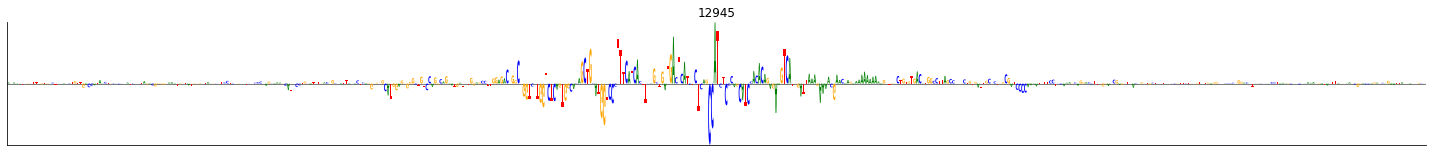

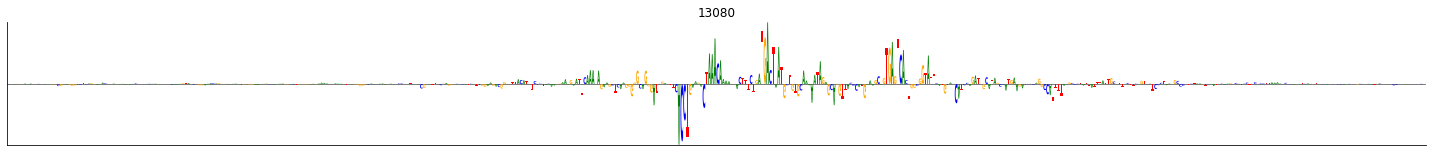

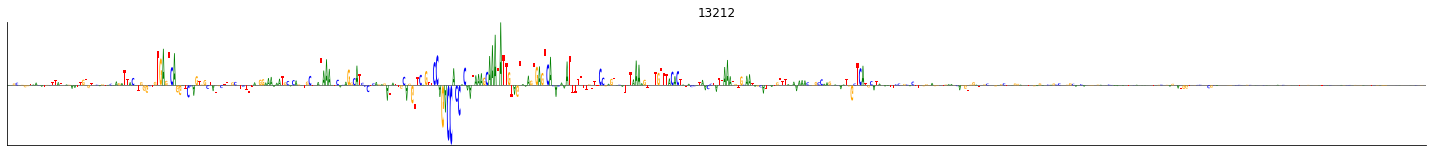

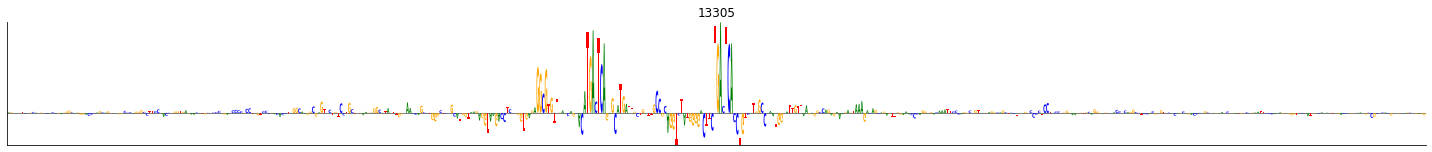

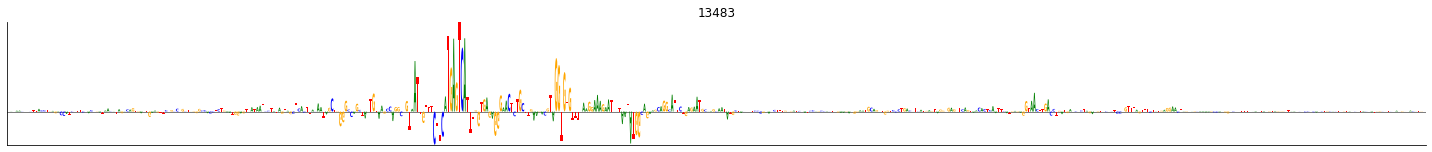

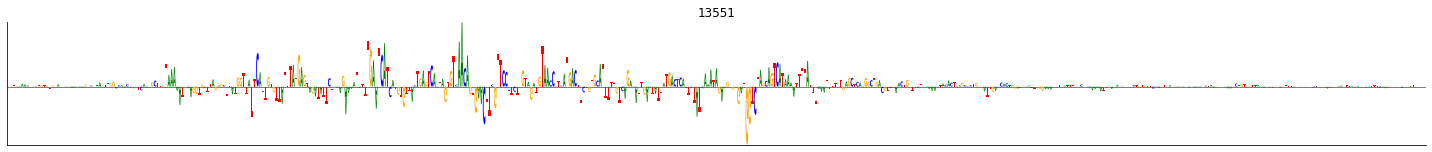

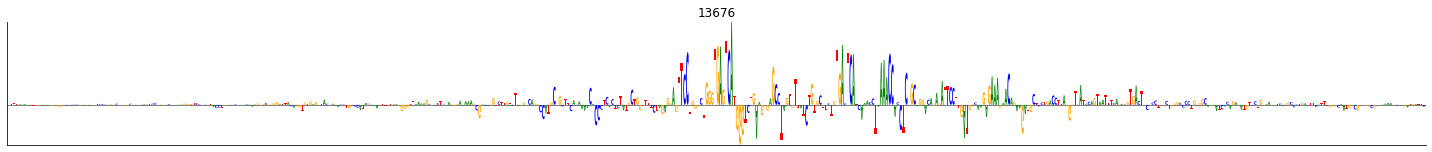

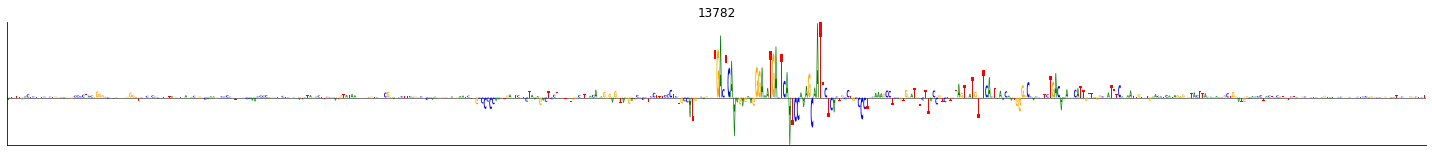

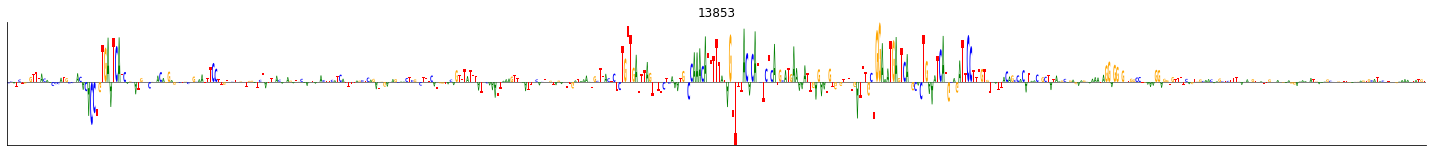

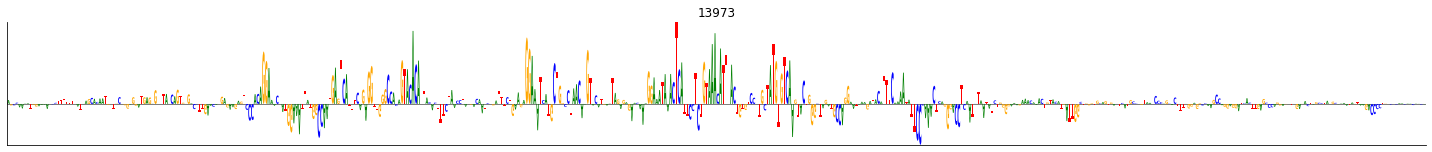

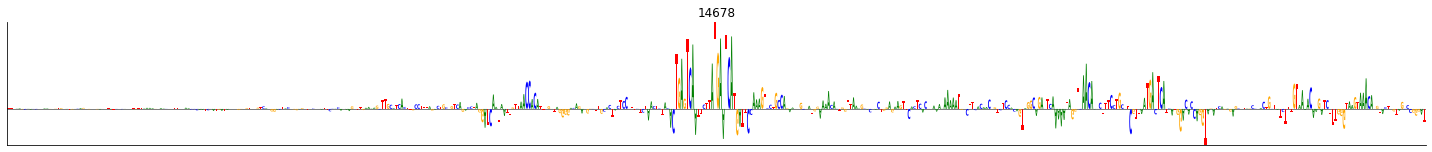

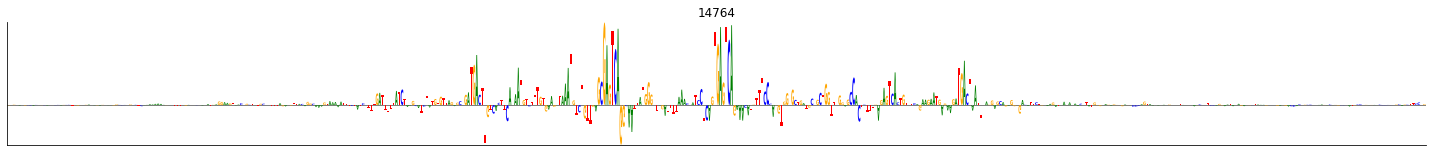

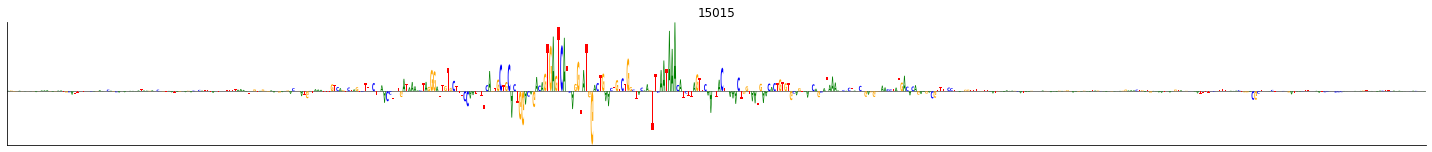

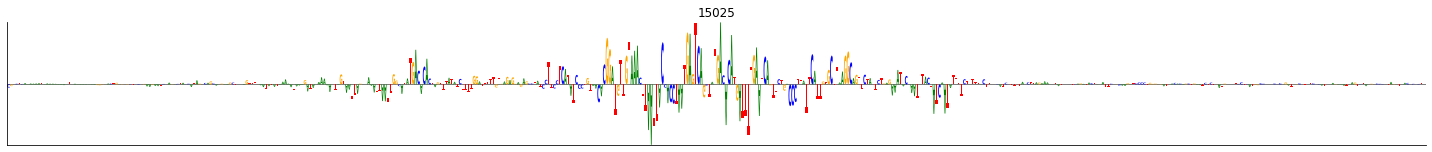

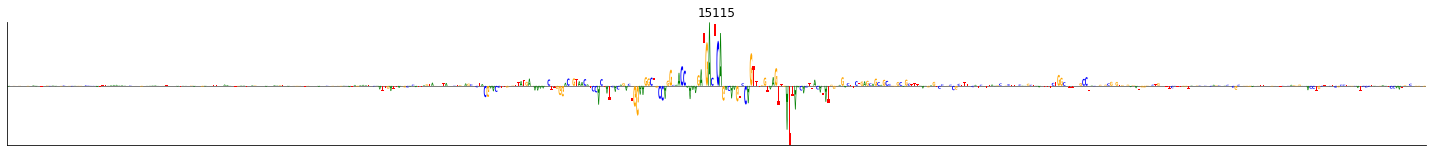

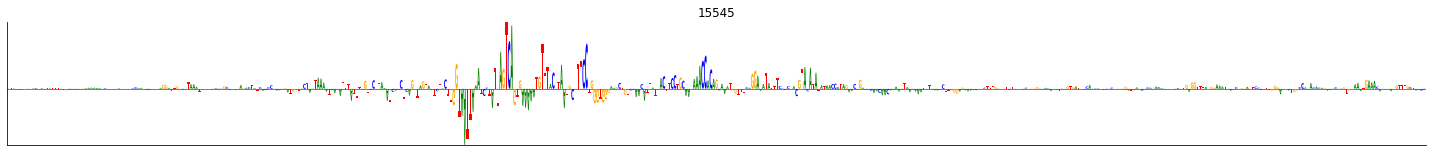

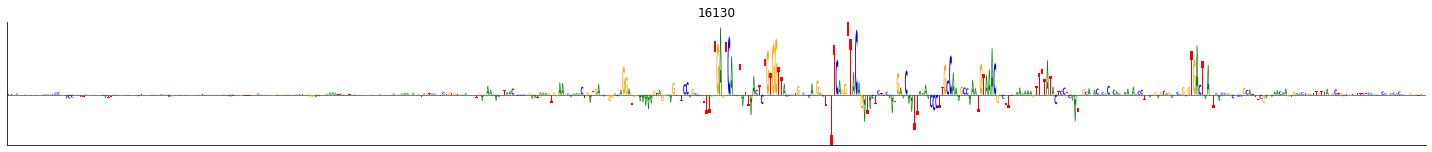

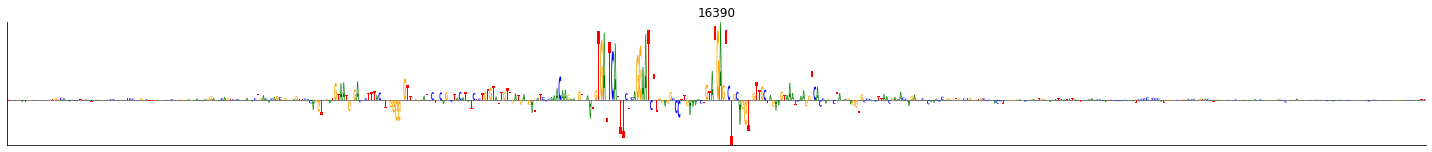

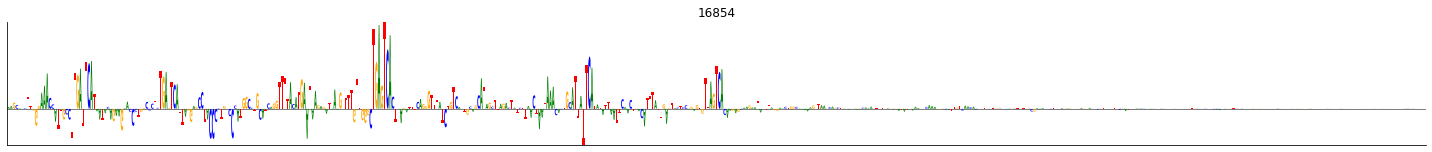

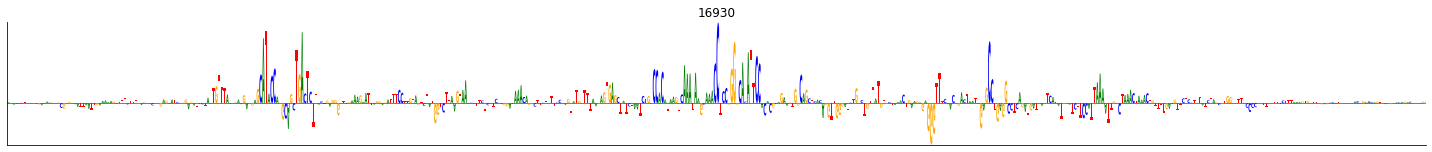

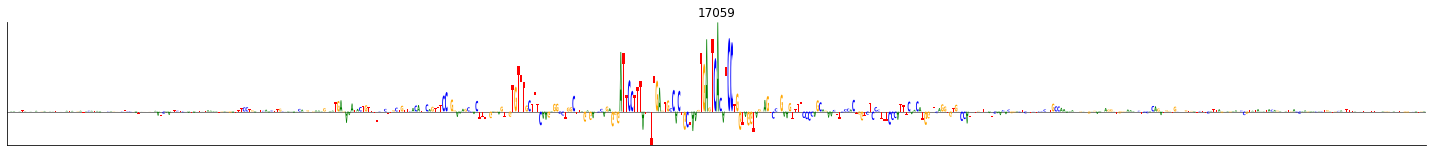

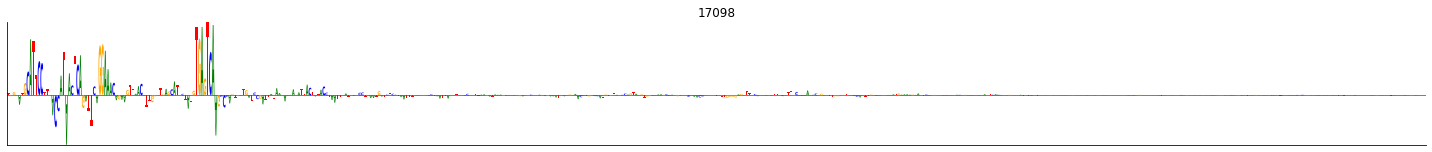

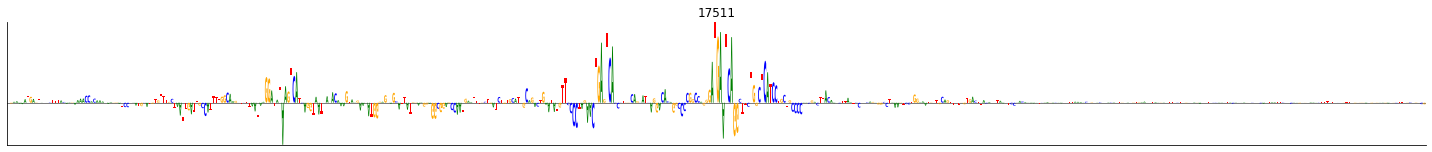

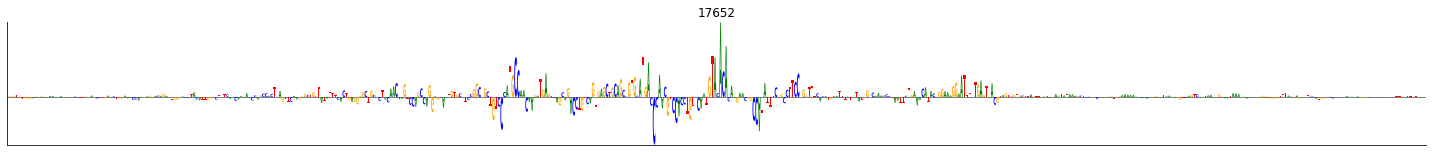

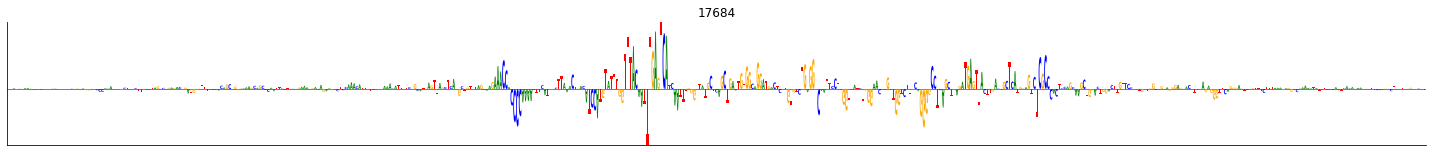

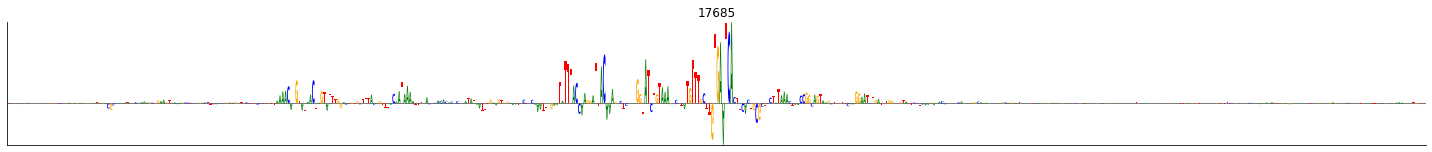

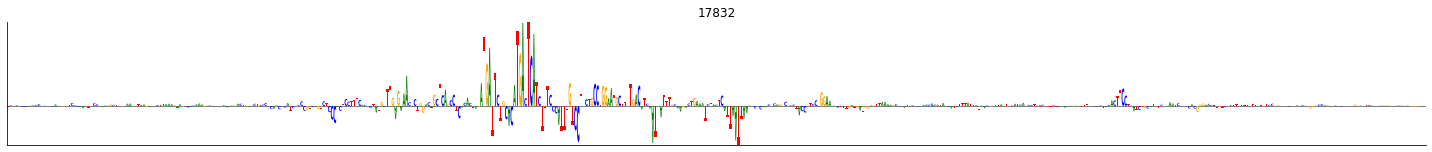

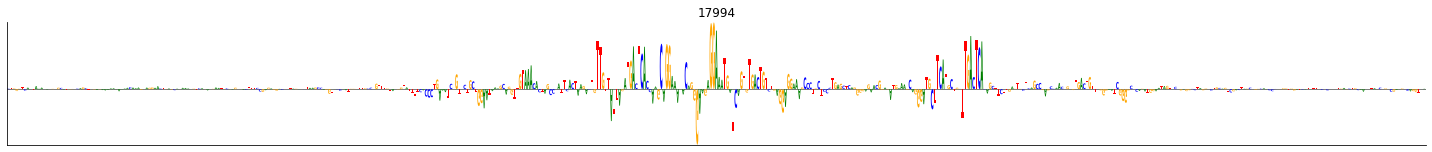

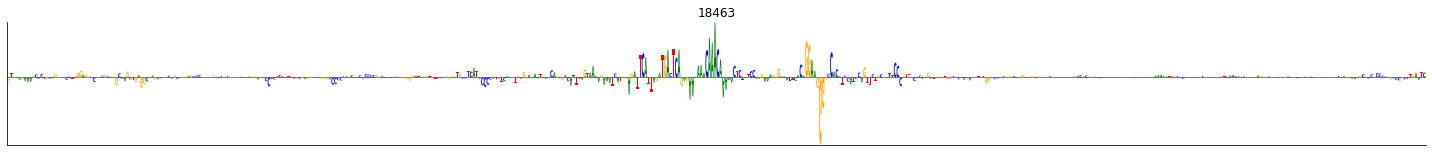

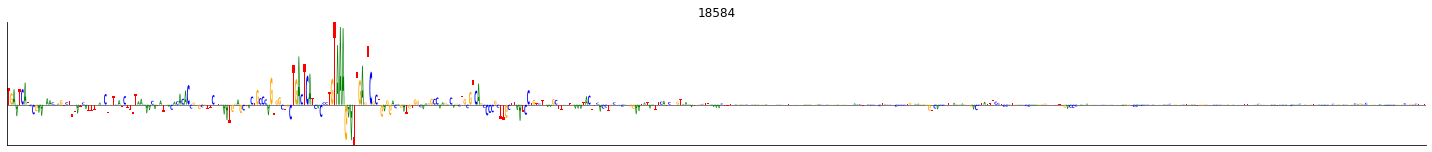

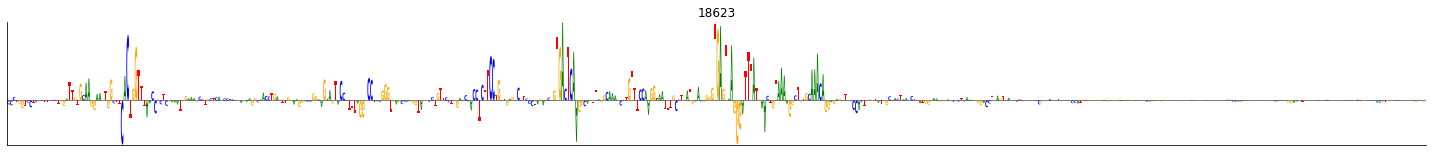

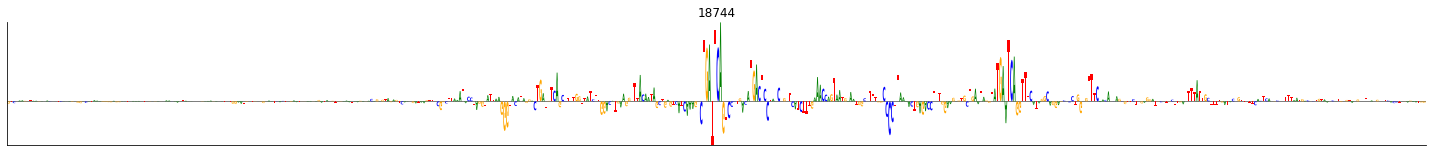

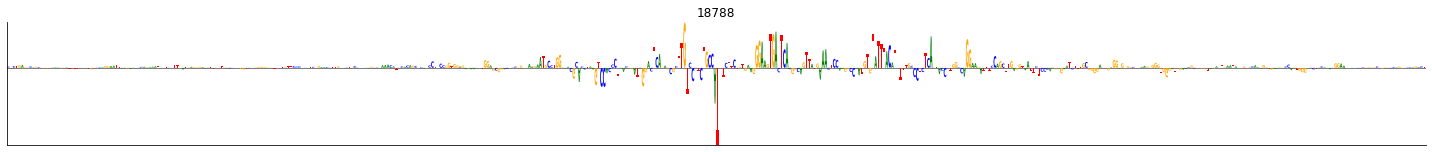

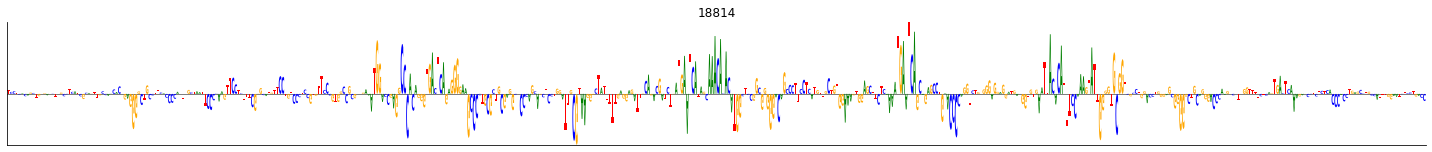

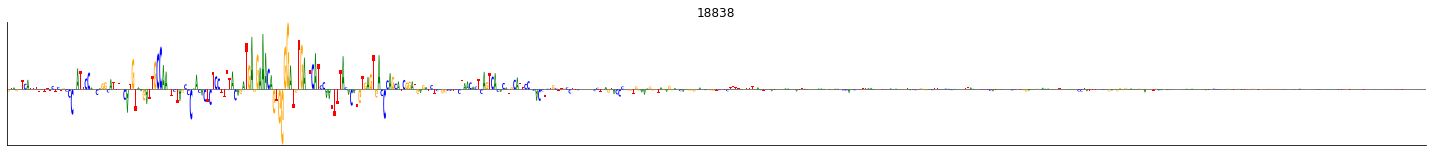

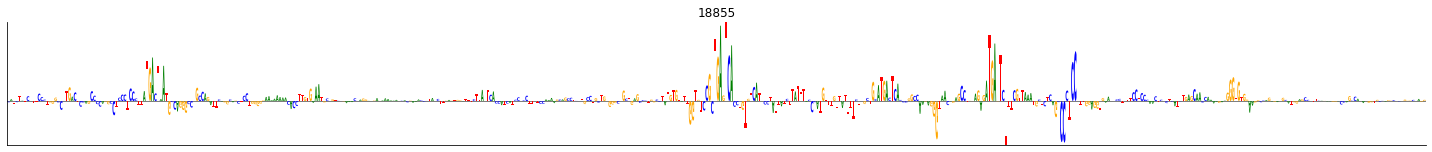

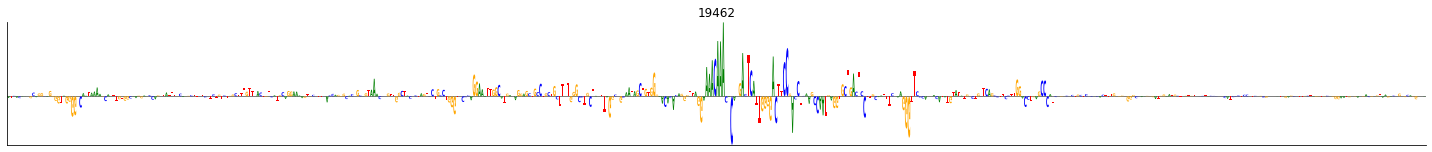

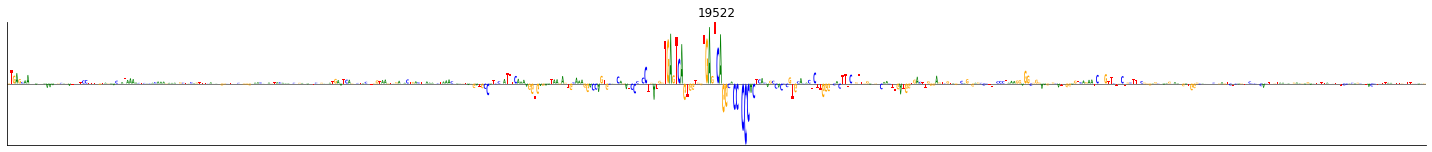

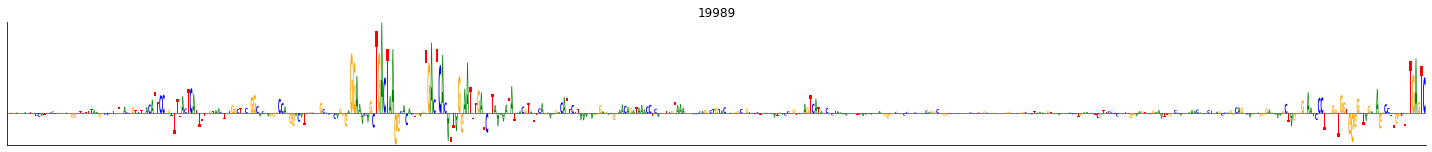

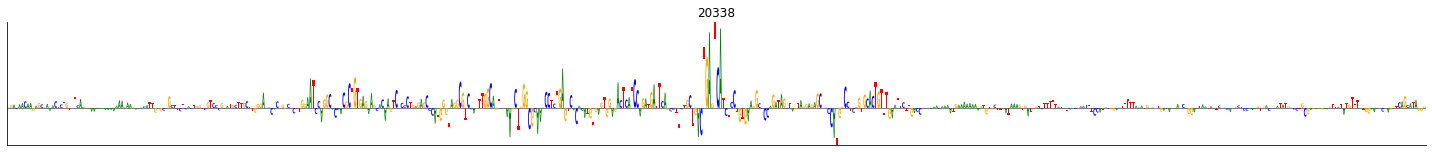

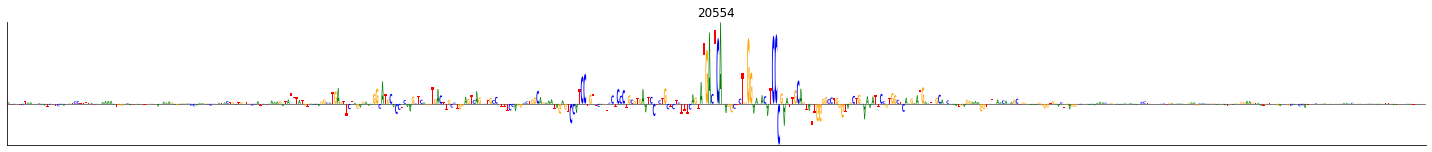

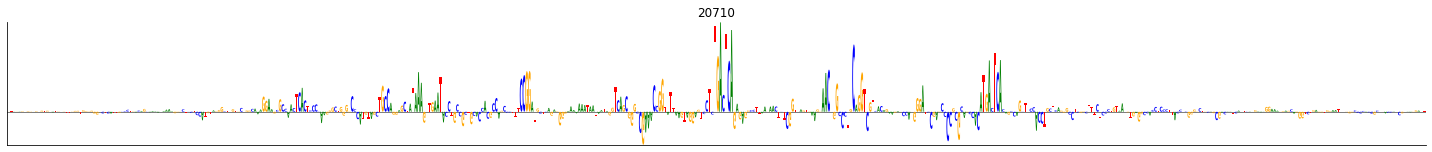

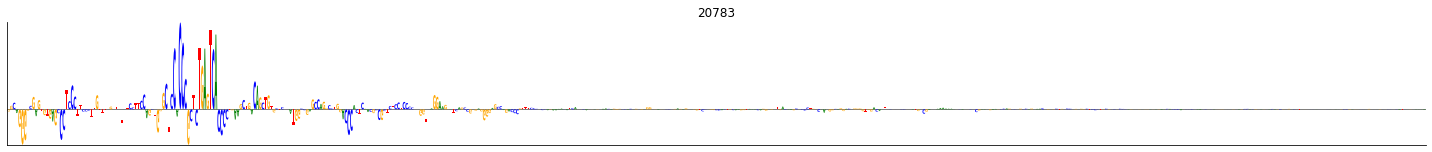

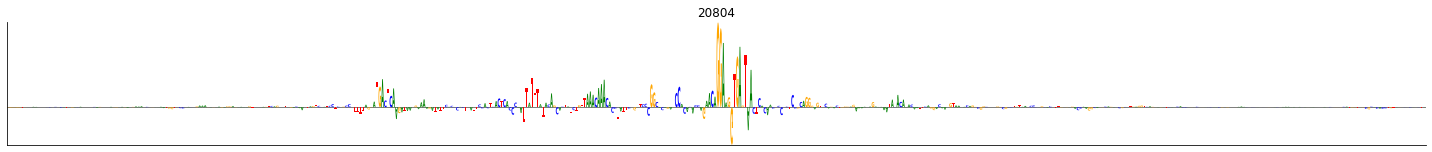

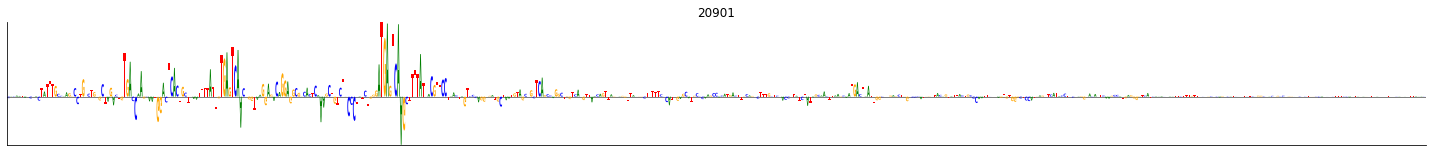

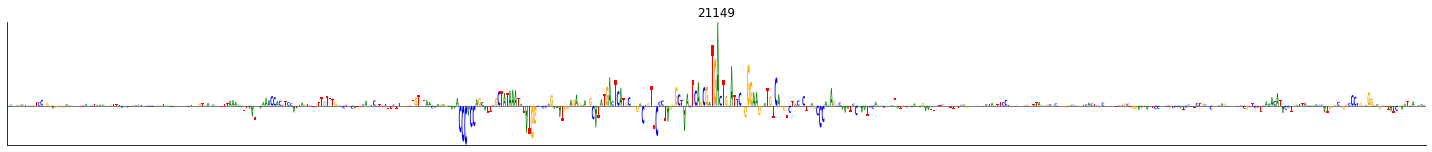

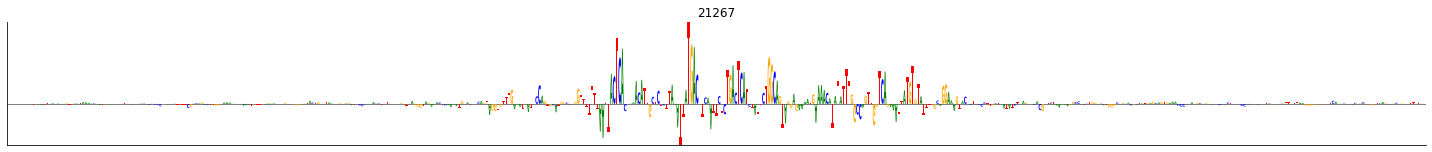

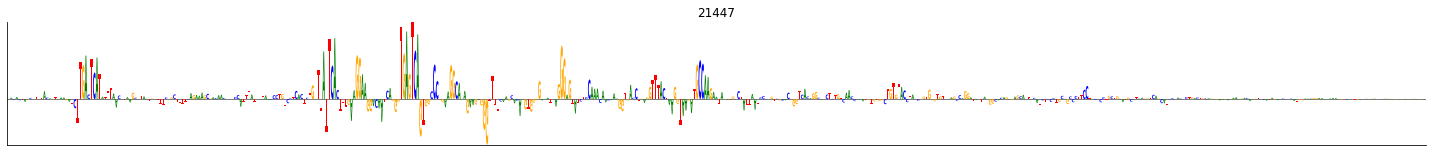

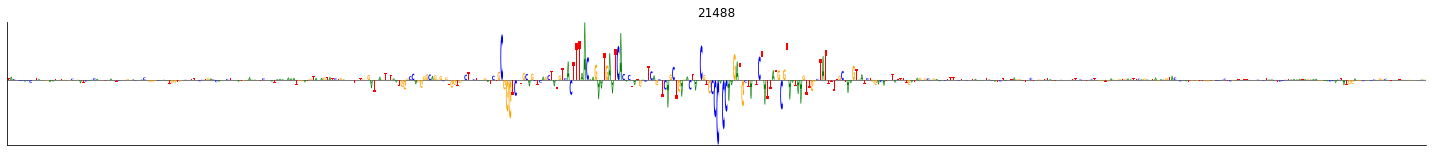

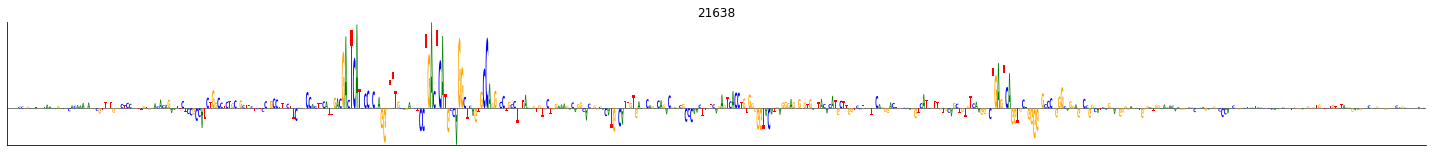

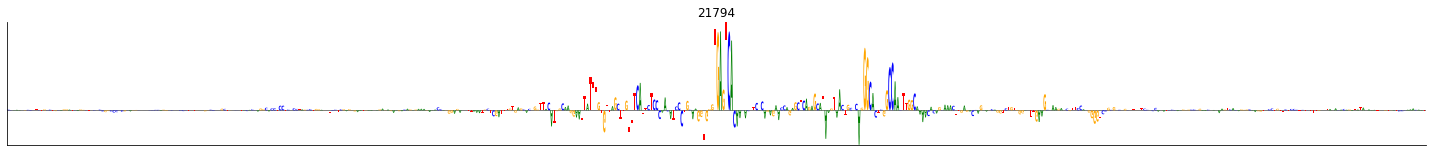

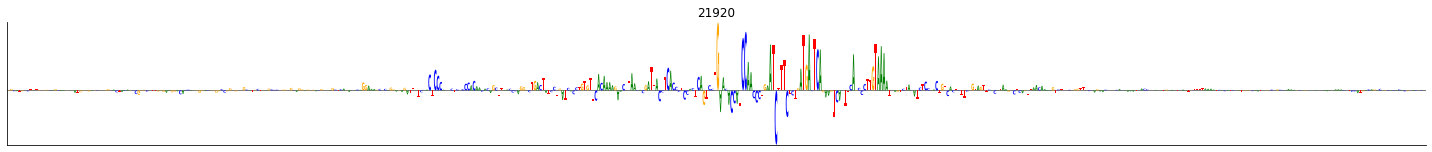

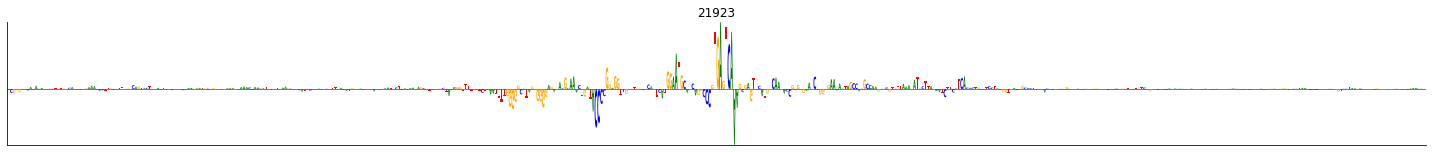

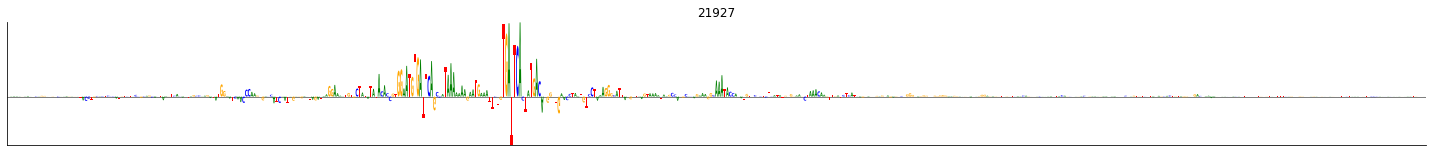

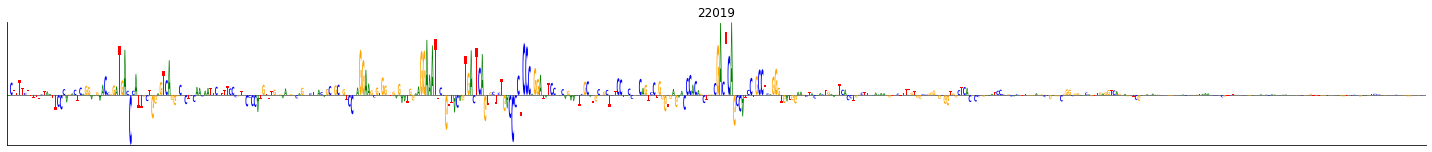

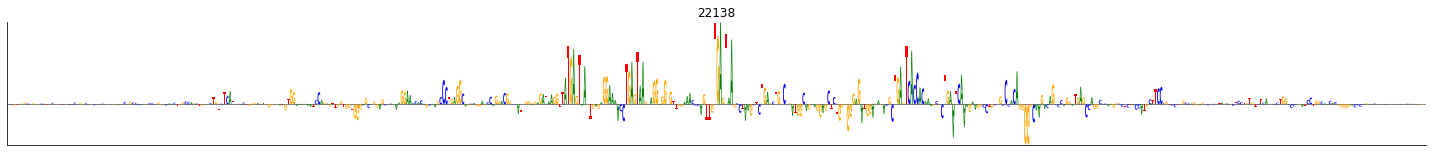

In [160]:
cell_line = 13
left_idr_motif_indx = find_seqs_with_motif(left_idr_indx, motif_pattern, thresholded_X, model, cell_line)
np.random.seed(42)
for i in left_idr_motif_indx:
    explainer = explain.Explainer(model, class_index=cell_line)
    X_sample = np.expand_dims(thresholded_X[i], axis=0)
    saliency_scores = explainer.saliency_maps(X_sample)
    # plot attribution maps in a narrow range about max saliency value
    explain.plot_saliency_logos(saliency_scores, X_sample, window=256)
    plt.title(str(i))
    #32

Text(0.5, 1.0, '7941')

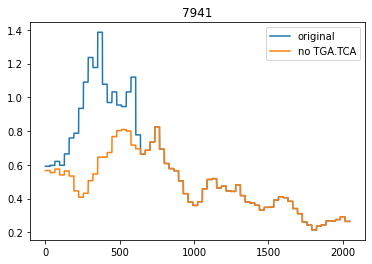

In [32]:
i = 7941
cell_line=13
plt.plot(np.repeat(predictions[i, :, cell_line], bin_size), label='original')
str_seq = ''.join(onehot_to_str(thresholded_X[i,:,:]))
grad_times_input = get_saliency_values(thresholded_X[i,:,:], model, cell_line)
motifs_and_indices = find_multiple_motifs([motif_pattern], str_seq, 
                     saliency_values=grad_times_input, filter_window=256)
selected_seq = thresholded_X[i,:,:]
modified_seq = randomize_motif_in_seq(motifs_and_indices, selected_seq)
no_motif_pred = model(np.expand_dims(modified_seq, axis=0))
plt.plot(np.repeat(no_motif_pred[0,:,cell_line], bin_size), label='no '+motif_pattern)
plt.legend(bbox_to_anchor=(1,1))
plt.title(str(i))

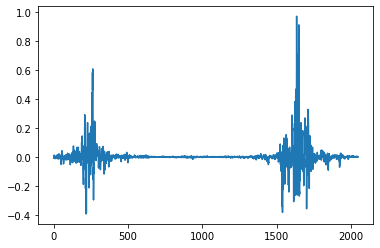

In [162]:
plt.plot(grad_times_input)

In [113]:
left_idr_indx

array([ 7568, 12976, 13305, 18149])

In [112]:
motif_patterns = ['TGA.TCA']
motif_delta_preds = []
cell_line = 13
cell_line_name = targets[cell_line]
# for cell_line, cell_line_name in enumerate(targets):
for motif_pattern in motif_patterns:
    delta_preds = []
    left_idr_motif_indx = find_seqs_with_motif(left_idr_indx, motif_pattern, thresholded_X, model, cell_line)
    print(len(left_idr_motif_indx))
    for i in left_idr_motif_indx:
        delta_pred = get_delta_per_seq(thresholded_X[i,:,:], motif_pattern, model, cell_line)
        delta_preds.append(delta_pred)
    df = pd.DataFrame(delta_preds, columns=['delta predictions'])
    df['motif'] = motif_pattern
    df['index'] = left_idr_motif_indx
    df['cell line'] = cell_line_name
    motif_delta_preds.append(df)
motif_delta_preds = pd.concat(motif_delta_preds)

3
0


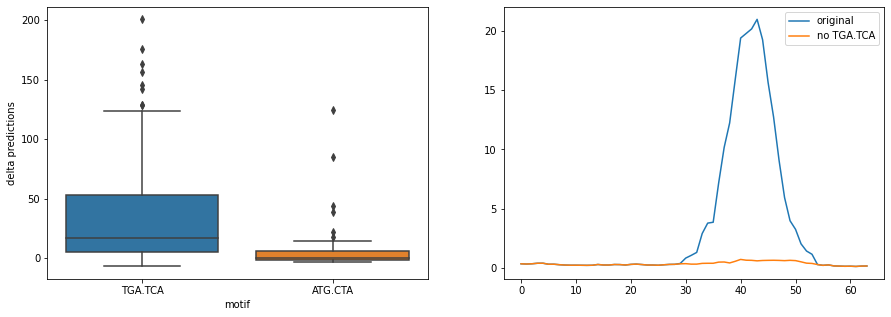

In [84]:
fig, axs = plt.subplots(1,2, figsize=[15,5])
sns.boxplot(x='motif', y='delta predictions', data=motif_delta_preds, ax=axs[0])
motif_pattern = 'TGA.TCA'
motif_df = motif_delta_preds[(motif_delta_preds['motif']==motif_pattern)]
i = motif_df.iloc[motif_df['delta predictions'].argmax(), 2]
str_seq = ''.join(onehot_to_str(thresholded_X[i,:,:]))
grad_times_input = get_saliency_values(thresholded_X[i,:,:], model, cell_line)
motifs_and_indices = find_multiple_motifs([motif_pattern], str_seq, 
                     saliency_values=grad_times_input, filter_window=256)
selected_seq = thresholded_X[i,:,:]
modified_seqs = randomize_motif_in_seq(motifs_and_indices, selected_seq)
no_motif_pred = model(modified_seq)[0,:,cell_line]
axs[1].plot(predictions[i,:,cell_line], label='original')
axs[1].plot(no_motif_pred, label='no '+motif_pattern)
axs[1].legend()


In [358]:
targets[cell_line]


'PC-3'

In [85]:
motif_pattern = 'TGA.TCA'
motif_delta_preds = []
for cell_line, cell_line_name in enumerate(targets):
    delta_preds = []
    left_idr_motif_indx = find_seqs_with_motif(best_seqs, motif_pattern, thresholded_X, model, cell_line)
    print(len(left_idr_motif_indx))
    for i in left_idr_motif_indx:
        delta_pred = get_delta_per_seq(thresholded_X[i,:,:], motif_pattern, model, cell_line)
        delta_preds.append(delta_pred)
    df = pd.DataFrame(delta_preds, columns=['delta predictions'])
    df['motif'] = motif_pattern
    df['index'] = left_idr_motif_indx
    df['cell line'] = cell_line_name
    motif_delta_preds.append(df)
motif_delta_preds = pd.concat(motif_delta_preds)

120
110
122
177
120
121
120
118
135
140
152
129
134
184
142


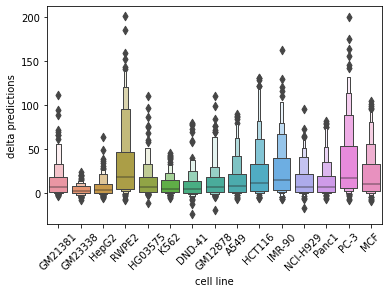

In [86]:
sns.boxenplot(x='cell line', y='delta predictions', data=motif_delta_preds)
plt.xticks(rotation=45);





In [326]:
from scipy.stats import mannwhitneyu
mannwhitneyu(motif_delta_preds[motif_delta_preds['cell line']=='PC-3']['delta predictions'], 
         motif_delta_preds[motif_delta_preds['cell line']=='GM21381']['delta predictions'])



MannwhitneyuResult(statistic=15098.0, pvalue=6.08577652962303e-08)

In [337]:
mask_by_hepg2 = np.argwhere(thresholded_Y[best_seqs][:,:,cell_line].max(axis=1)>5)

In [345]:
top_preds = best_seqs[np.argsort(predictions[best_seqs][:,:,cell_line].max(axis=1))[-10:]]

In [346]:
top_preds

array([22924,  3234, 47952, 54291,  3876,  7618, 23575, 27902,  3097,
       16923])

HepG2


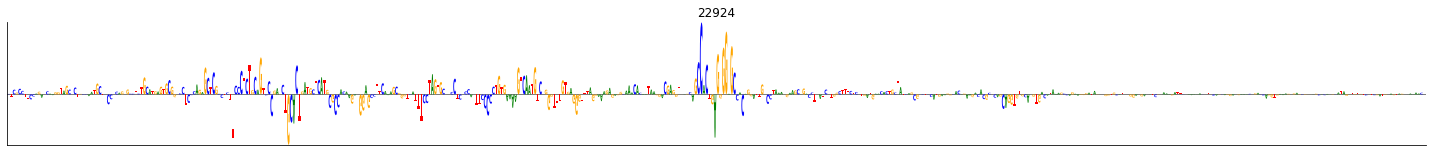

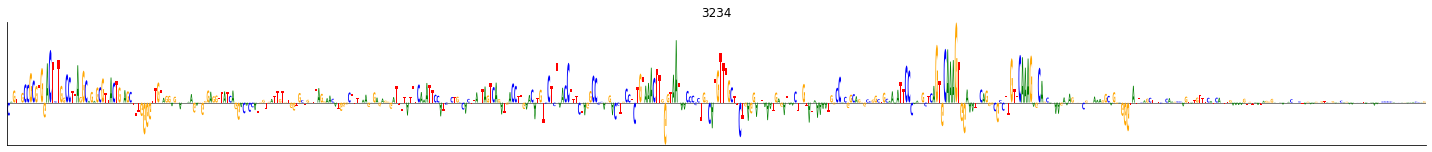

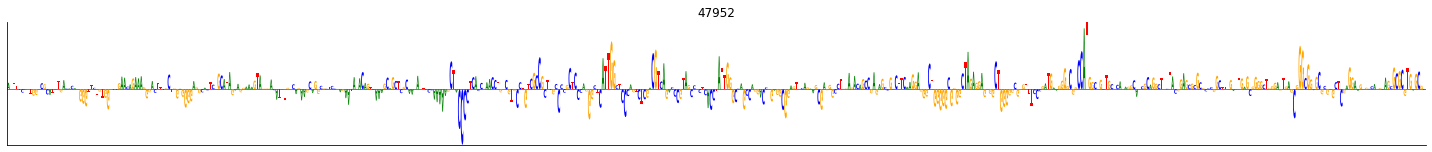

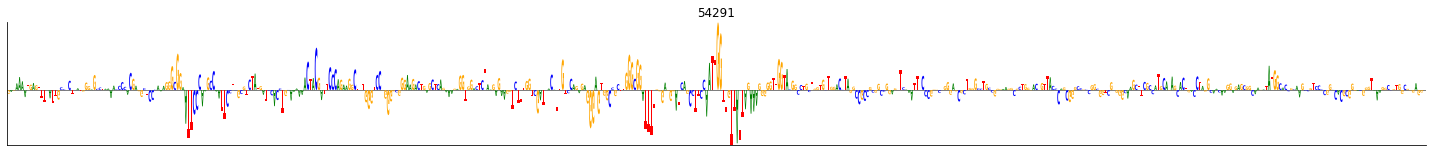

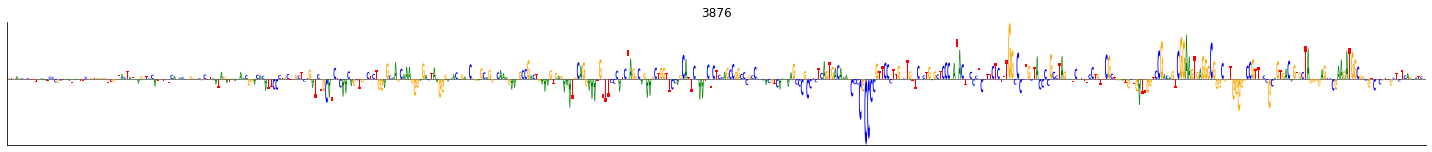

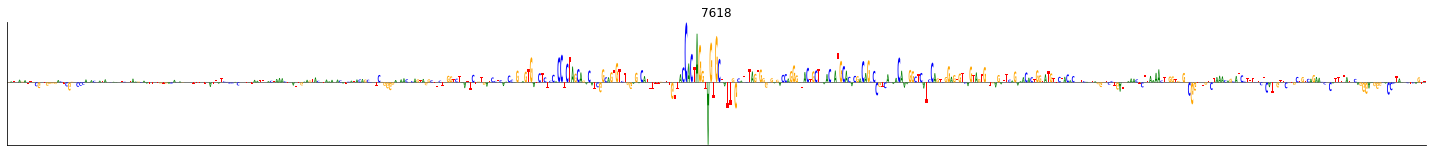

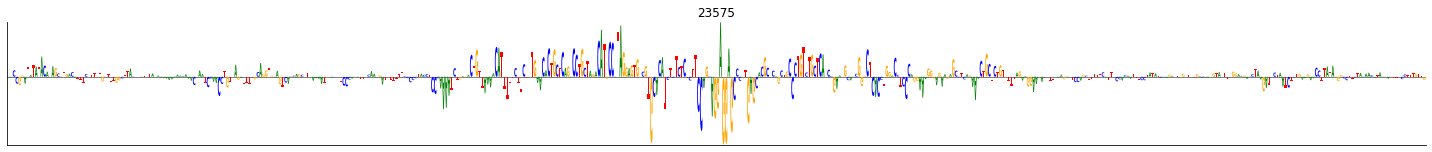

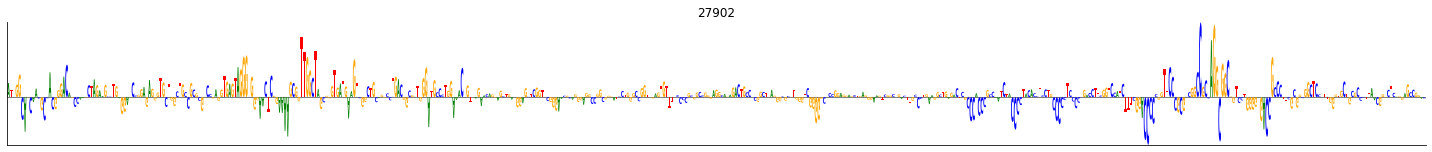

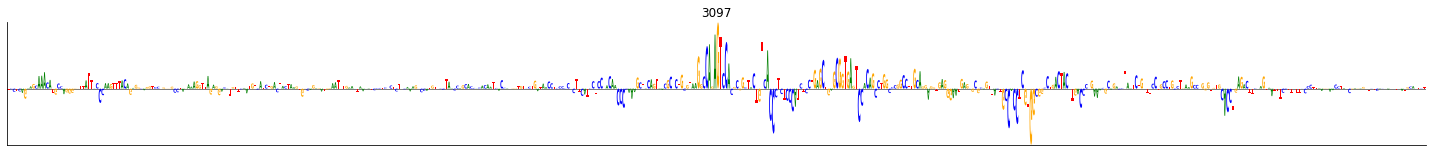

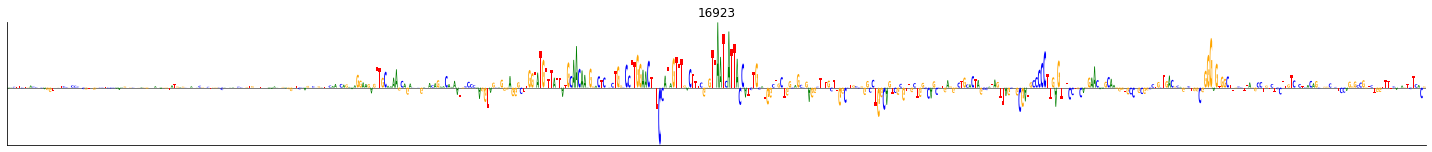

In [348]:
cell_line = 2
print(targets[cell_line])
# left_idr_motif_indx = find_seqs_with_motif(best_seqs[mask_by_hepg2], motif_pattern, thresholded_X, model, cell_line)
np.random.seed(42)
for i in top_preds:
    explainer = explain.Explainer(model, class_index=cell_line)
    X_sample = np.expand_dims(thresholded_X[i], axis=0)
    saliency_scores = explainer.saliency_maps(X_sample)
    # plot attribution maps in a narrow range about max saliency value
    explain.plot_saliency_logos(saliency_scores, X_sample, window=256)
    plt.title(str(i))

# Choose sequences based on seamonster


In [119]:
cell_line = 13
threshold_mask = (Y[:,:,cell_line].max(axis=1)>threshold)
thresholded_Y = Y[:,:,cell_line][threshold_mask]
thresholded_X = X[threshold_mask]

predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)



In [118]:
thresholded_Y.shape

(23346, 2048, 15)

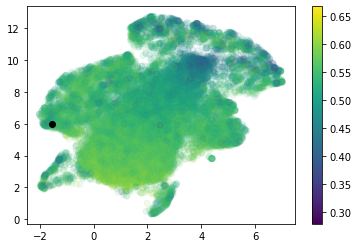

In [117]:
embeddings = np.load('embeddings.npy', allow_pickle=True)
embeddings = pd.DataFrame(embeddings[:,:-2], columns=['UMAP 1', 'UMAP 2', 'IDR', 'cell line'])

GC_content_all = get_GC_content(thresholded_X)
embeddings['GC content'] = GC_content_all

plt.scatter(x=embeddings['UMAP 1'], 
                y=embeddings['UMAP 2'],
                alpha=0.1,
                c=embeddings['GC content'],
               cmap='viridis_r')
plt.scatter(x=embeddings['UMAP 1'][2177], 
                y=embeddings['UMAP 2'][2177],c='k')

plt.clim(np.percentile(GC_content_all, 1),np.percentile(GC_content_all, 99))
c = plt.colorbar()
# plt.legend(bbox_to_anchor=(1,1));

In [ ]:
N, L, C = thresholded_Y.shape
binned_Y = thresholded_Y.reshape(N, L//bin_size, bin_size, C).mean(axis=-2)
mse = metrics.get_mse(binned_Y, 
                      predictions).mean(axis=1).mean(axis=-1)
pr = metrics.get_correlation_per_seq(binned_Y, 
                      predictions, take_avg=False)        
pr=np.array(pr).mean(axis=0)